## Setup, Loading Data and CDFs

In [ ]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'wavelet-horizVert'
CHANNEL = 'blue'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
red_wavelet_full_agriVision.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/michaelmurphy/Documents/GitHub/hierarchical-bayesian-model-validation/results/case-studies/agriVision/full/wavelet/red'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 9000,
 3: 36000,
 4: 144000,
 5: 576000,
 6: 2304000,
 7: 9216000,
 8: 36864000,
 9: 147456000,
 10: 589824000}

Running 12760 CDFs


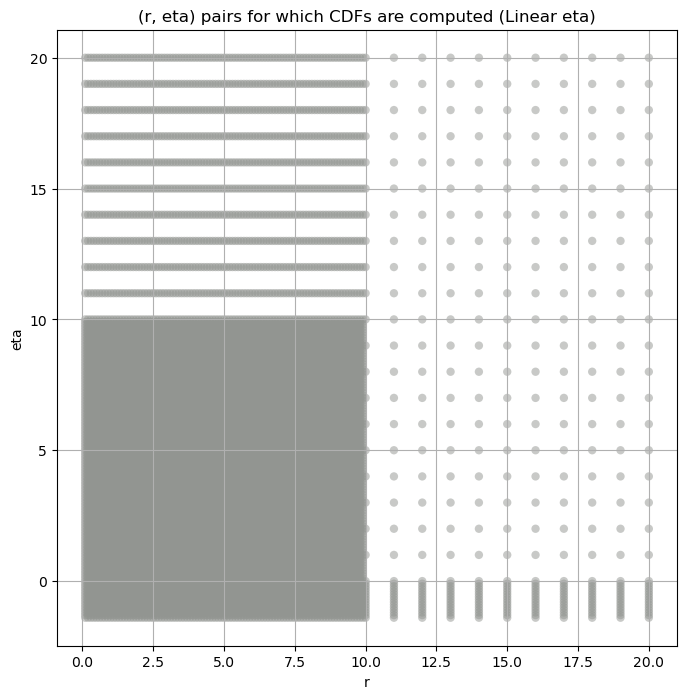

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 10


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var      var_lower      var_upper     obs_kurt  kurt_lower  \
layer                                                                         
2      179849.670000  104861.120000  313799.060000    501.36950   36.679760   
3       48276.574000   29688.229000   75748.940000    352.49057   90.250230   
4       13505.842000    6427.289000   29258.977000   1066.33460  112.394750   
5        3324.662400    1098.296600   15507.862000   6605.85100   86.610340   
6         902.707800     217.919700    6910.355000  18930.71300   76.715860   
7         249.830380      58.962917    1794.096000  19065.92400   51.230747   
8          57.422370      22.250046     277.044700   8522.20500   61.003616   
9          14.426312       5.903421      62.549038   6464.18550   77.169460   
10          2.155396       0.812531       9.592564   6981.02830   80.402470   

       kurt_upper  total_samples  
layer                             
2       756.93090           9000  
3       561.88666          36000  
4      2700.87100         144000  
5      7123.14500         576000  
6      8727.08600        2304000  
7      8605.30900        9216000  
8      6912.42770       36864000  
9      6431.98000      147456000  
10     6665.14160      589824000

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                 
2      179849.670000  179849.671875    74068.046875    64211.027344   
3       48276.574000   48276.574219    24034.875000    19635.275391   
4       13505.842000   13505.841797     6691.468750     5463.545898   
5        3324.662400    3324.662354     1151.641602      984.349976   
6         902.707800     902.707825      228.017136      195.524841   
7         249.830380     249.830383       61.203598       54.042839   
8          57.422370      57.422371       23.217773       20.164927   
9          14.426312      14.426311        6.167904        5.232007   
10          2.155396       2.155396        0.853747        0.722454   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        57748.882812     52651.132812     44625.554688     38720.996094   
3        17825.396484     16572.769531     14752.135742     13399.104492   
4         4914.754395      4542.564941      4026.512207      3661.758057   
5          881.451294       806.043152       703.316650       634.355164   
6          176.659195       163.698624       146.237076       134.353424   
7           49.994183        47.162109        43.218170        40.454025   
8           18.466160        17.350565        15.912366        14.965271   
9            4.736511         4.422393         4.022895         3.761109   
10           0.652426         0.607176         0.548583         0.509734   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2         34185.230469     30431.990234     27312.775391     20459.427734  
3         12318.069336     11442.975586     10709.843750      9000.989258  
4          3397.134766      3186.979492      3012.686279      2606.322998  
5           583.992371       545.068848       513.397095       444.263062  
6           125.500946       118.509605       112.747734        99.978523  
7            38.342278        36.639549        35.216217        31.985025  
8            14.259912        13.696917        13.226177        12.141318  
9             3.566251         3.411159         3.282097         2.987487  
10            0.480745         0.457657         0.438503         0.395207

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.016574785502810774 179849.67


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.011223031021615815 74068.05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.012664995777083132 64211.027


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.014864922936865699 57748.883


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.0172692608426388 52651.133


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.02325166308905091 44625.555


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.028654404957278445 38720.996


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.03340609588239929 34185.23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.03770212277604834 30431.99


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.04362164071808605 27312.775


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.05925489336926599 20459.428
Number of samples: 9000, Without approximation : 9000


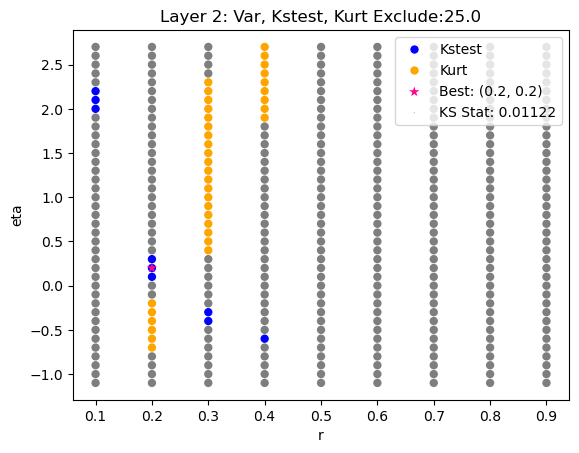

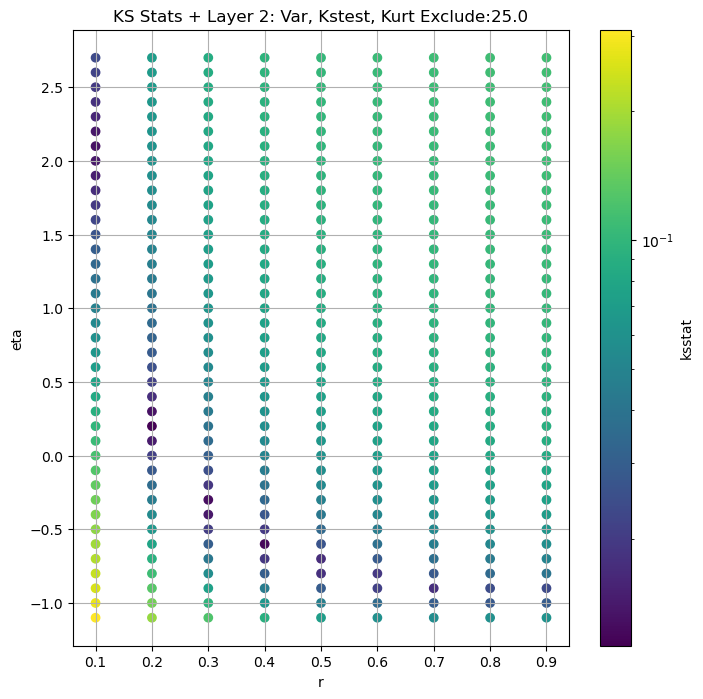

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.023480647352931525 48276.574


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.014211499931760185 24034.875


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.01123248307891922 19635.275


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.01144197375521816 17825.396


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.010991222571841874 16572.77


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.010553798603412212 14752.136


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.012286161468010315 13399.1045


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.01233991454578498 12318.069


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.013948201674805483 11442.976


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.015545899813828923 10709.844


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.019063965729636534 9000.989
Number of samples: 36000, Without approximation : 36000


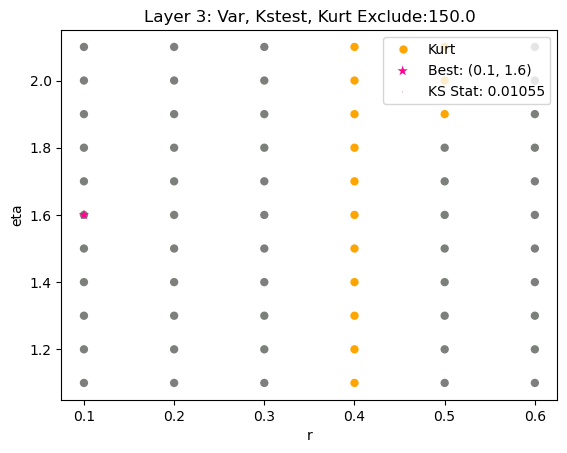

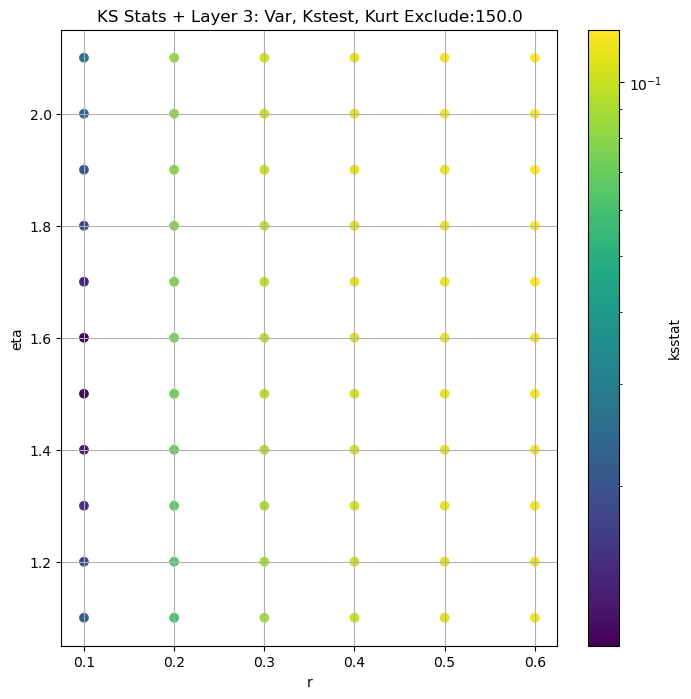

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.03119559101696967 13505.842


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.02078622893672928 6691.4688


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.017880765240329125 5463.546


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.015599088770186925 4914.7544


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.01470325464129063 4542.565


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.010826324294359202 4026.5122


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.009603902248722873 3661.758


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.008721823136752738 3397.1348


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.007623079209405748 3186.9795


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.006804824502901791 3012.6863


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.008186184591563755 2606.323
Number of samples: 100000, Without approximation : 144000


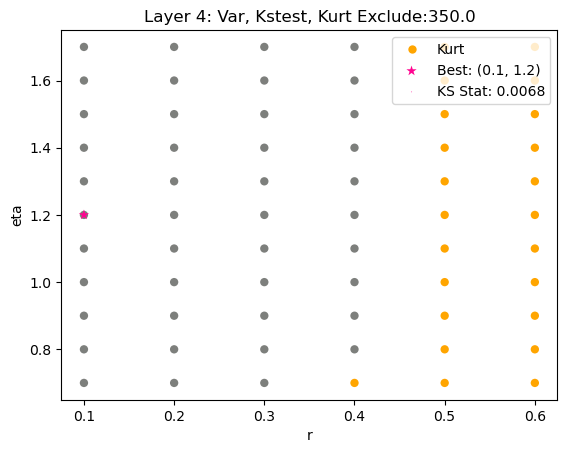

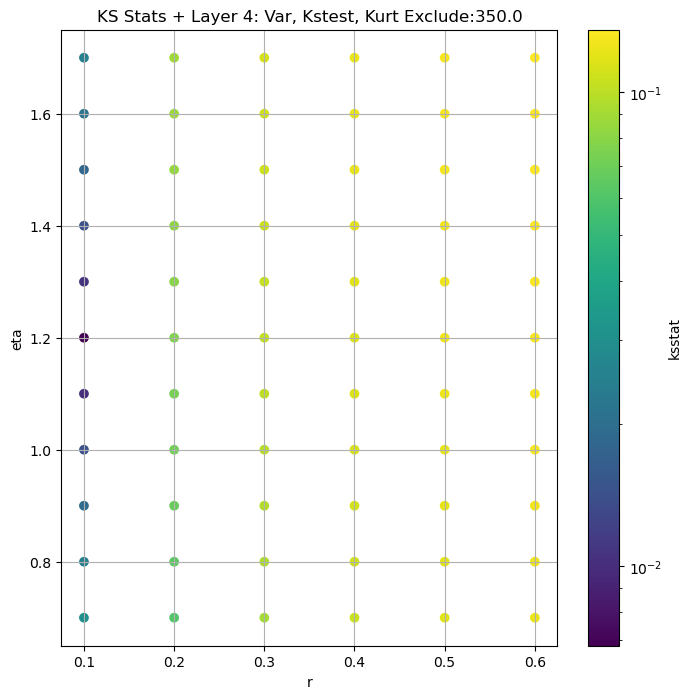

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.03962962797368219 3324.6624


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.021355214068890738 1151.6416


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.01677867099851632 984.35


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.016120360571941106 881.4513


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.01449383207085933 806.04315


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.011531158751661136 703.31665


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.009524657826073368 634.35516


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.006957662469071188 583.9924


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.006506392922210669 545.06885


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.006046386688303151 513.3971


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.0077777705848602885 444.26306
Number of samples: 100000, Without approximation : 576000


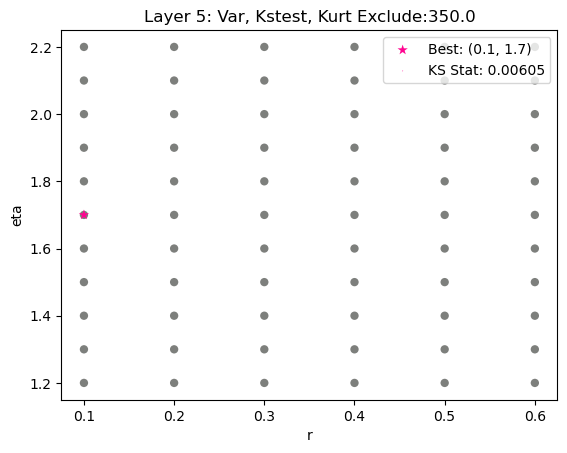

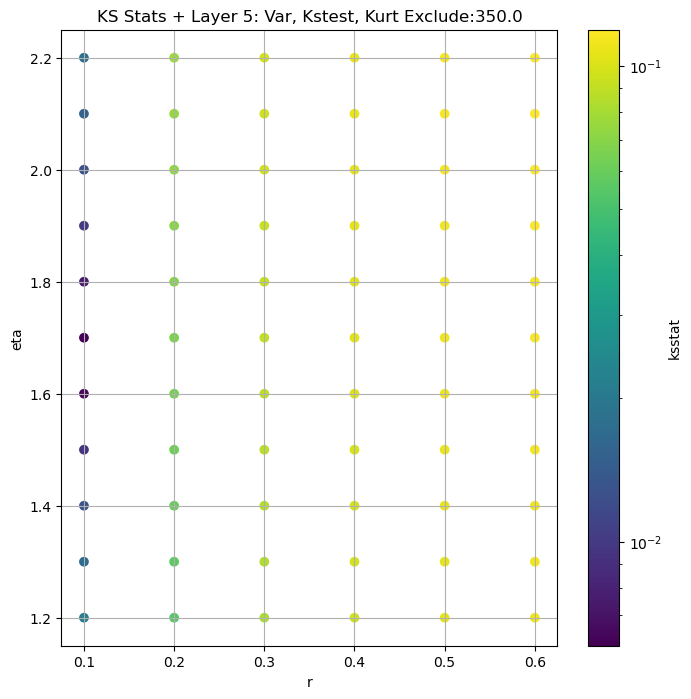

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.04206868374305953 902.7078


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.016526584246700685 228.01714


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.012717481599075875 195.52484


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.010542185699621676 176.6592


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.008422256071560622 163.69862


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.005987194463906442 146.23708


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.004445235945095383 134.35342


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.003902944733172875 125.500946


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.004506357904111247 118.509605


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.0050732058505156274 112.747734


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.006839596625600519 99.97852
Number of samples: 100000, Without approximation : 2304000


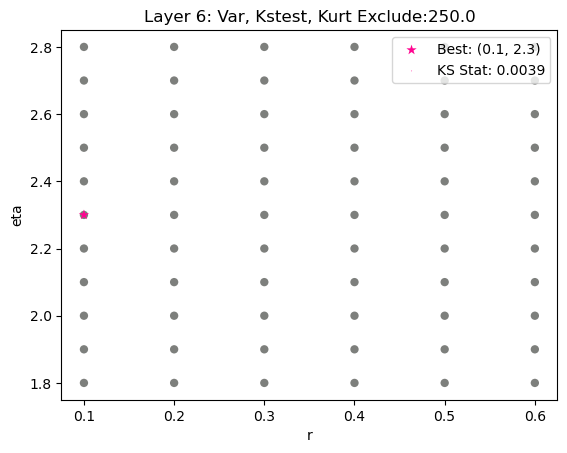

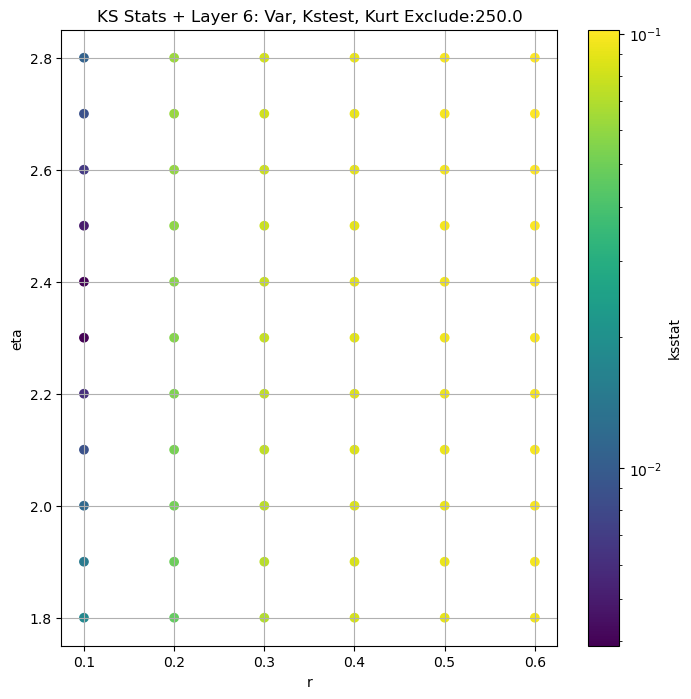

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.03822981350940474 249.83038


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.011400835436676027 61.203598


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.008106838211099254 54.04284


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.0058195330416768165 49.994183


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.004451479344344311 47.16211


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.0028344454169968447 43.21817


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.003008038596019502 40.454025


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.003629155040344223 38.342278


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.004289360619677995 36.63955


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.005017004044408524 35.216217


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.006855211927783711 31.985025
Number of samples: 100000, Without approximation : 9216000


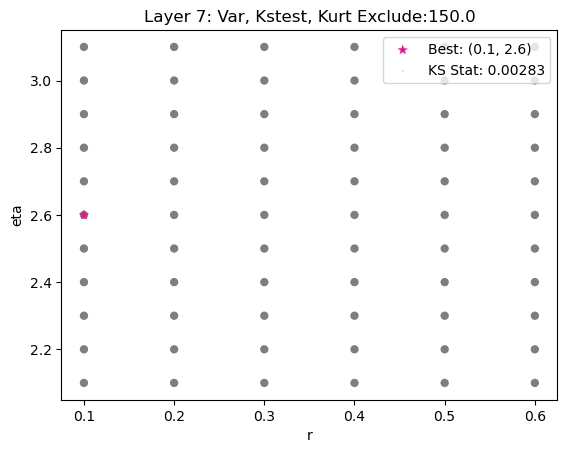

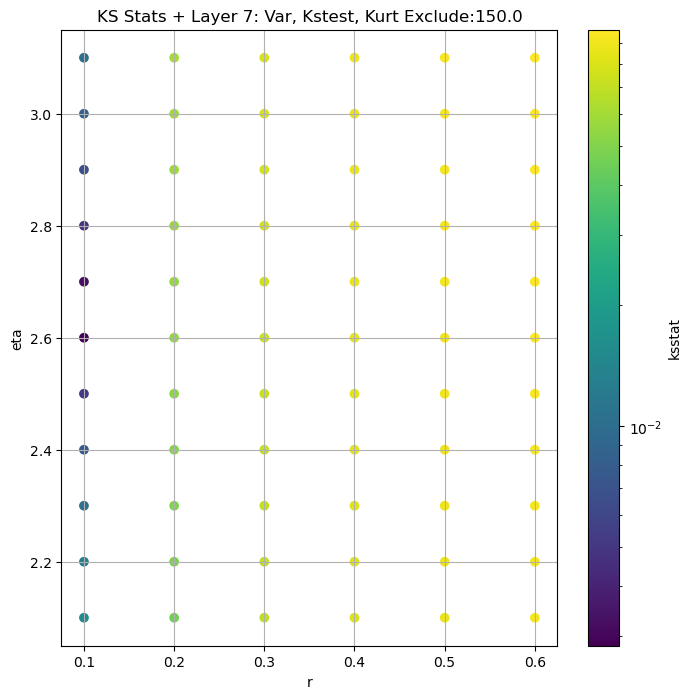

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.028627244815702446 57.42237


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.009218634055152664 23.217773


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.00500469587025365 20.164927


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.003010495132258484 18.46616


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.002365526821532793 17.350565


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.0020965447576800633 15.912366


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.002835925606992973 14.965271


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.0036070357685898946 14.2599125


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.004499884459190029 13.696917


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.005169635869480493 13.226177


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.007058424050305434 12.141318
Number of samples: 100000, Without approximation : 36864000


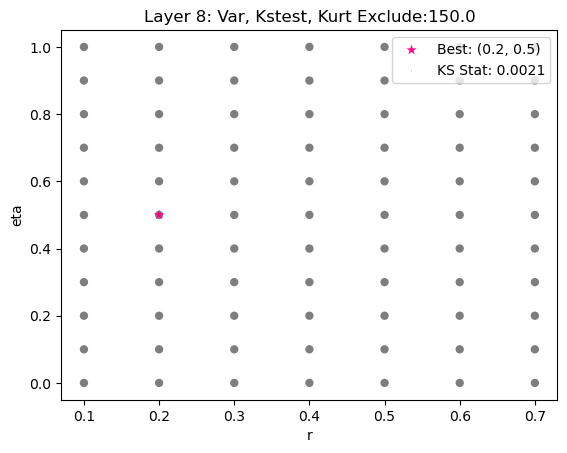

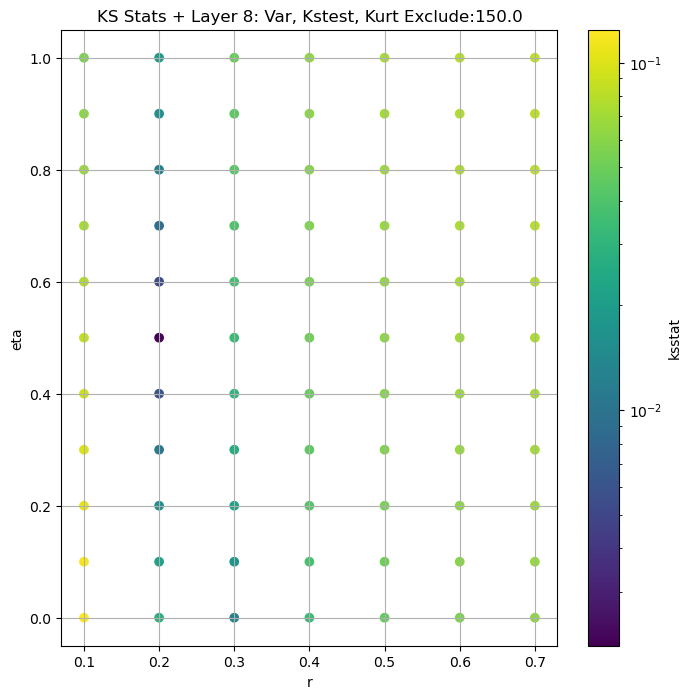

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.02960226862381471 14.4263115


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.011629258363853201 6.1679044


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.008455966170874185 5.2320065


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.006283472170221738 4.7365108


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.004789015707898303 4.422393


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.0029921100258080147 4.022895


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.0031420247061722407 3.7611094


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.0038188724943761763 3.5662506


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.004735563640235016 3.411159


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.0053047167295077365 3.2820969


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.007237226770296326 2.9874868
Number of samples: 100000, Without approximation : 147456000


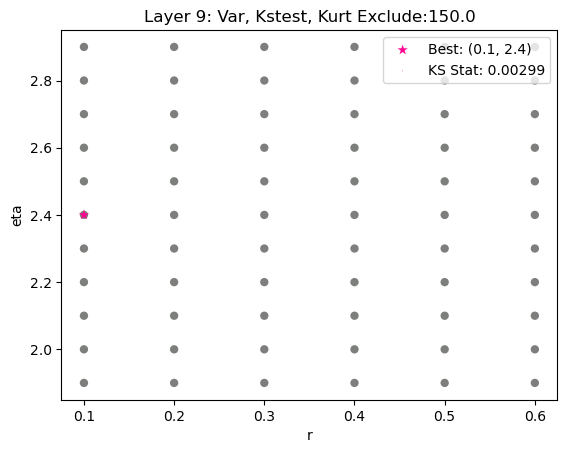

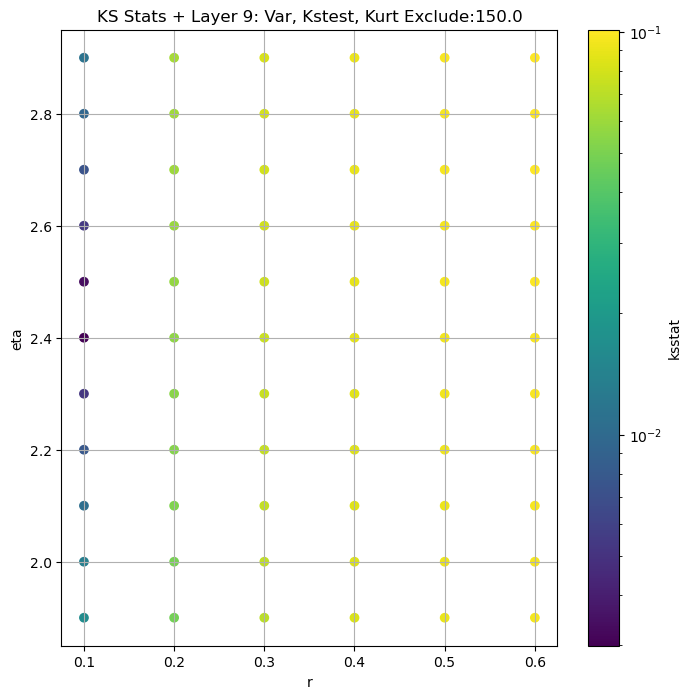

####
Layer  10


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 0 0.03461967110946673 2.1553957


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 25 0.016476680927046086 0.85374737


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 50 0.012762443624186437 0.7224544


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 75 0.011315377977988386 0.6524259


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 100 0.009875968928586998 0.6071757


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 150 0.007754391131044924 0.5485829


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 200 0.006089129279045036 0.50973415


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 250 0.005641782640040893 0.48074538


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 300 0.005529460057404123 0.45765728


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 350 0.005955426881443376 0.438503


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 500 0.007441097717346357 0.39520675
Number of samples: 100000, Without approximation : 589824000


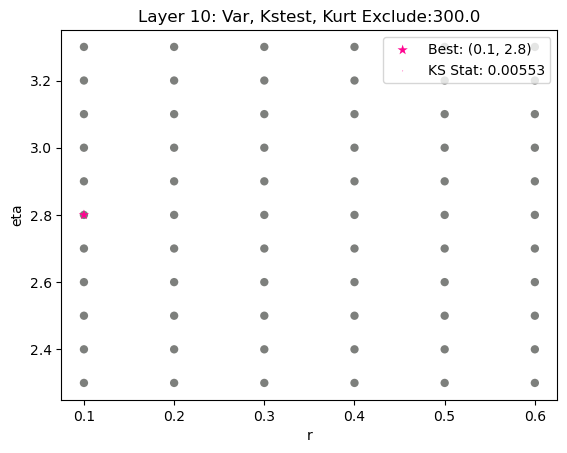

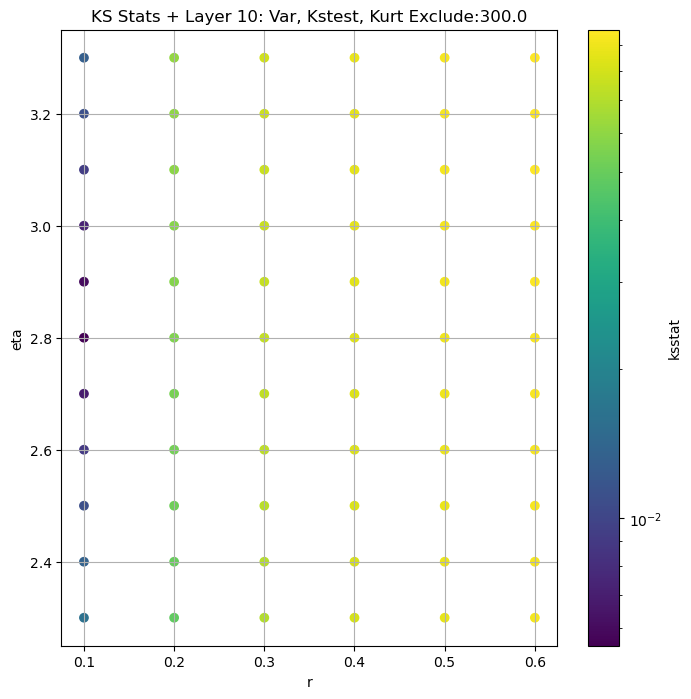

obs_var      var_lower      var_upper     obs_kurt  kurt_lower  \
layer                                                                         
2      179849.670000  104861.120000  313799.060000    501.36950   36.679760   
3       48276.574000   29688.229000   75748.940000    352.49057   90.250230   
4       13505.842000    6427.289000   29258.977000   1066.33460  112.394750   
5        3324.662400    1098.296600   15507.862000   6605.85100   86.610340   
6         902.707800     217.919700    6910.355000  18930.71300   76.715860   
7         249.830380      58.962917    1794.096000  19065.92400   51.230747   
8          57.422370      22.250046     277.044700   8522.20500   61.003616   
9          14.426312       5.903421      62.549038   6464.18550   77.169460   
10          2.155396       0.812531       9.592564   6981.02830   80.402470   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       756.93090           9000             0.011223        0.2          0.2   
3       561.88666          36000             0.010554        0.1          1.6   
4      2700.87100         144000             0.006805        0.1          1.2   
5      7123.14500         576000             0.006046        0.1          1.7   
6      8727.08600        2304000             0.003903        0.1          2.3   
7      8605.30900        9216000             0.002834        0.1          2.6   
8      6912.42770       36864000             0.002097        0.2          0.5   
9      6431.98000      147456000             0.002992        0.1          2.4   
10     6665.14160      589824000             0.005529        0.1          2.8   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       6.077028e-01                    25.0        74068.050000   
3       4.795898e-12                   150.0        14752.136000   
4       3.266162e-12                   350.0         3012.686300   
5       1.261962e-13                   350.0          513.397100   
6       6.679075e-15                   250.0          125.500946   
7       1.159409e-15                   150.0           43.218170   
8       6.623529e-05                   150.0           15.912366   
9       1.694925e-16                   150.0            4.022895   
10      7.972053e-18                   300.0            0.457657   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.014297  
3                     0.007153  
4                     0.003578  
5                     0.001789  
6                     0.000895  
7                     0.000447  
8                     0.000224  
9                     0.000112  
10                    0.000056

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
layer 2, 25.0 + 100 = 125, ksstat: 0.022471749361485438, var: 48305.48828125


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
layer 2, 25.0 + 75 = 100, ksstat: 0.019584988451579632, var: 52651.1328125


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
layer 2, 25.0 + 50 = 75, ksstat: 0.016729642010893997, var: 57748.8828125


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
layer 2, 25.0 + 25 = 50, ksstat: 0.013726622720681925, var: 64211.02734375


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
layer 2, 25.0 + 0 = 25, ksstat: 0.010457057029368277, var: 74068.046875


  0%|          | 0/879 [00:00<?, ?it/s]

Finding Minimum after computing 879 CDFs
layer 2, 25.0 + -25 = 0, ksstat: 0.018219431110942708, var: 179849.671875
Number of samples: 9000, Without approximation : 9000


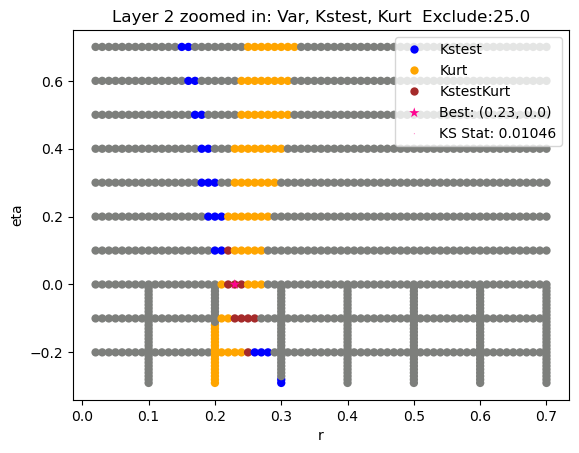

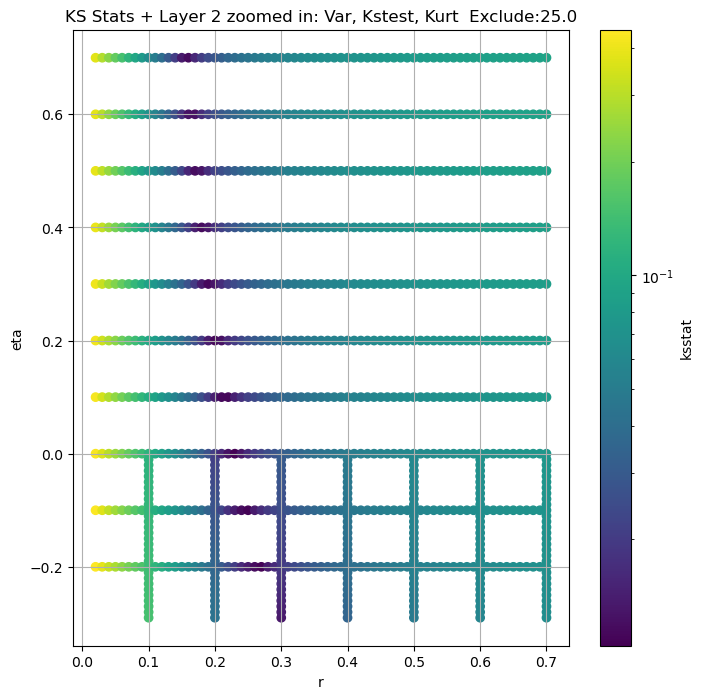

Layer 3


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 150.0 + 100 = 250, ksstat: 0.014464388900356395, var: 12318.0693359375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 150.0 + 75 = 225, ksstat: 0.013800854917788763, var: 12829.626953125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 150.0 + 50 = 200, ksstat: 0.012778706142808849, var: 13399.1044921875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 150.0 + 25 = 175, ksstat: 0.011584247901892608, var: 14038.2861328125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 150.0 + 0 = 150, ksstat: 0.010352401342312967, var: 14752.1357421875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 150.0 + -25 = 125, ksstat: 0.009710214274153195, var: 15569.2626953125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 150.0 + -50 = 100, ksstat: 0.009386347257130168, var: 16572.76953125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 150.0 + -75 = 75, ksstat: 0.010075250491619281, var: 17825.396484375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 150.0 + -100 = 50, ksstat: 0.010609204341784029, var: 19635.275390625
Number of samples: 36000, Without approximation : 36000


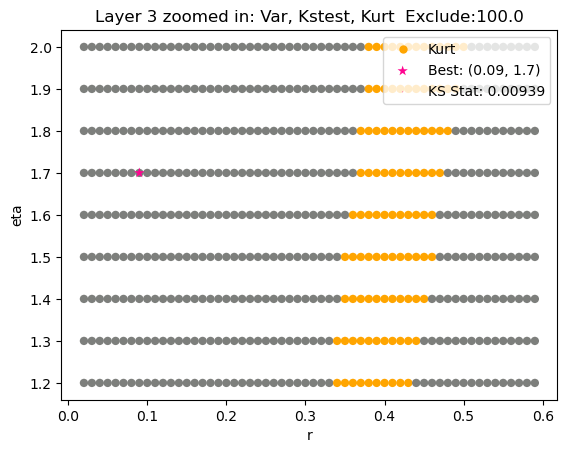

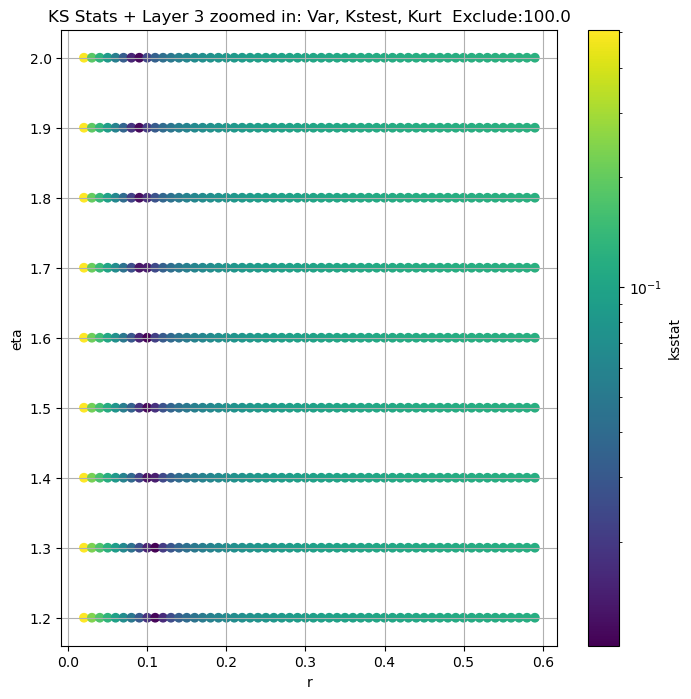

Layer 4


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 350.0 + 100 = 450, ksstat: 0.00787828282782239, var: 2726.21826171875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 350.0 + 75 = 425, ksstat: 0.007467873275111794, var: 2791.045166015625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 350.0 + 50 = 400, ksstat: 0.007167782376663377, var: 2860.23876953125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 350.0 + 25 = 375, ksstat: 0.007054669468791436, var: 2934.054443359375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 350.0 + 0 = 350, ksstat: 0.006804824502901791, var: 3012.686279296875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 350.0 + -25 = 325, ksstat: 0.007649023981541991, var: 3096.429931640625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 350.0 + -50 = 300, ksstat: 0.007623079209405748, var: 3186.9794921875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 350.0 + -75 = 275, ksstat: 0.008444534985433239, var: 3286.431884765625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 350.0 + -100 = 250, ksstat: 0.008413656214139587, var: 3397.134765625
Number of samples: 100000, Without approximation : 144000


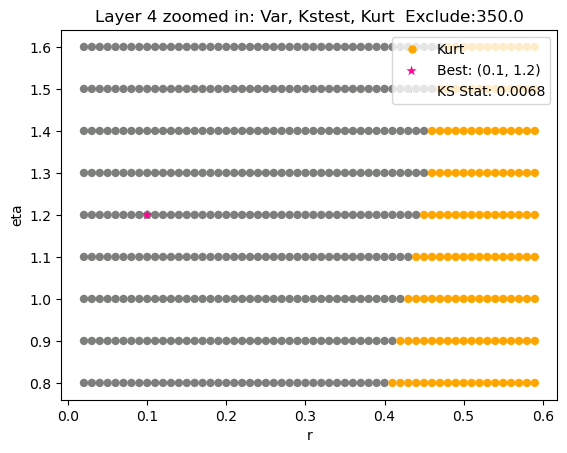

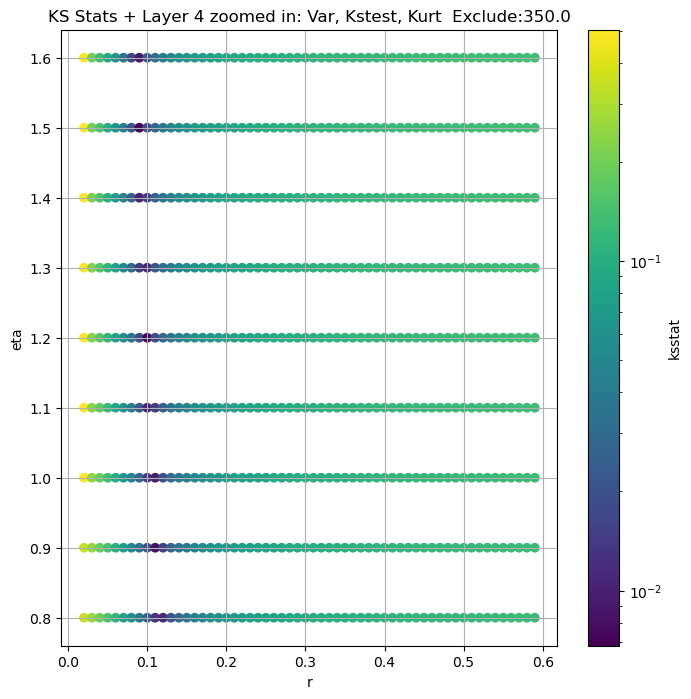

Layer 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 100 = 450, ksstat: 0.007362701586048015, var: 464.2040710449219


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 75 = 425, ksstat: 0.007009998888974356, var: 475.2177429199219


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 50 = 400, ksstat: 0.006663927342967391, var: 487.0138854980469


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 25 = 375, ksstat: 0.006328788493273785, var: 499.6758117675781


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + 0 = 350, ksstat: 0.006029608356894145, var: 513.3970947265625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -25 = 325, ksstat: 0.005694762458827496, var: 528.4514770507812


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -50 = 300, ksstat: 0.0054068127399539145, var: 545.06884765625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -75 = 275, ksstat: 0.00626620714442061, var: 563.4728393554688


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 350.0 + -100 = 250, ksstat: 0.006957662469071188, var: 583.9923706054688
Number of samples: 100000, Without approximation : 576000


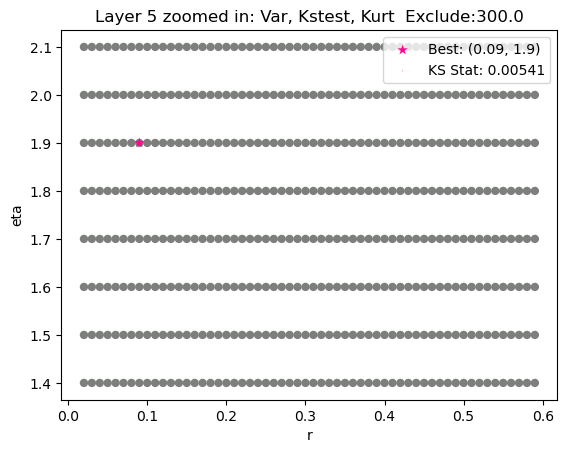

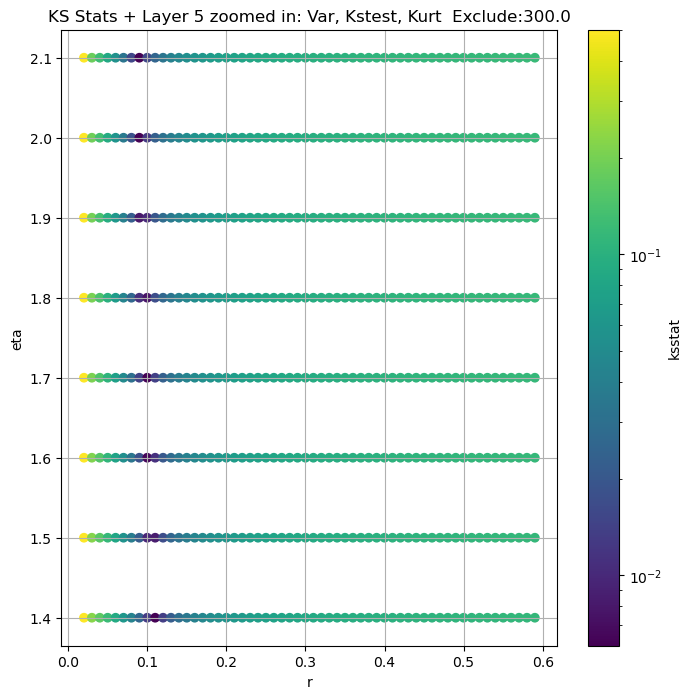

Layer 6


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 6, 250.0 + 100 = 350, ksstat: 0.005183881265969914, var: 112.74773406982422


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 6, 250.0 + 75 = 325, ksstat: 0.0047960296799739455, var: 115.50052642822266


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 6, 250.0 + 50 = 300, ksstat: 0.004486282774067707, var: 118.50960540771484


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 6, 250.0 + 25 = 275, ksstat: 0.004171103214457905, var: 121.82357788085938


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 6, 250.0 + 0 = 250, ksstat: 0.003902944733172875, var: 125.50094604492188


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 6, 250.0 + -25 = 225, ksstat: 0.0036367558980473502, var: 129.64242553710938


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 6, 250.0 + -50 = 200, ksstat: 0.00394634196807829, var: 134.35342407226562


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 6, 250.0 + -75 = 175, ksstat: 0.004828987965859621, var: 139.81138610839844


  0%|          | 0/580 [00:00<?, ?it/s]

Finding Minimum after computing 580 CDFs
layer 6, 250.0 + -100 = 150, ksstat: 0.005608963390718716, var: 146.23707580566406
Number of samples: 100000, Without approximation : 2304000


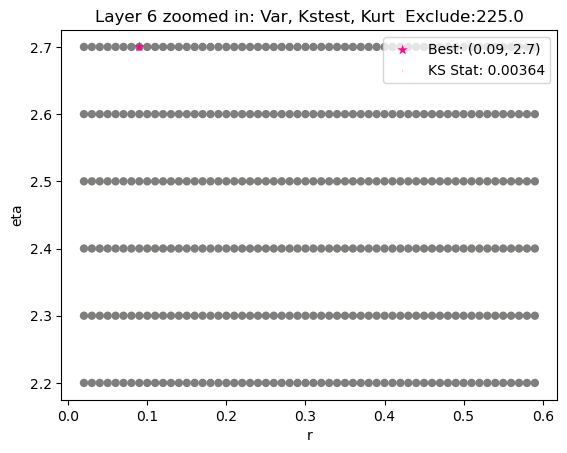

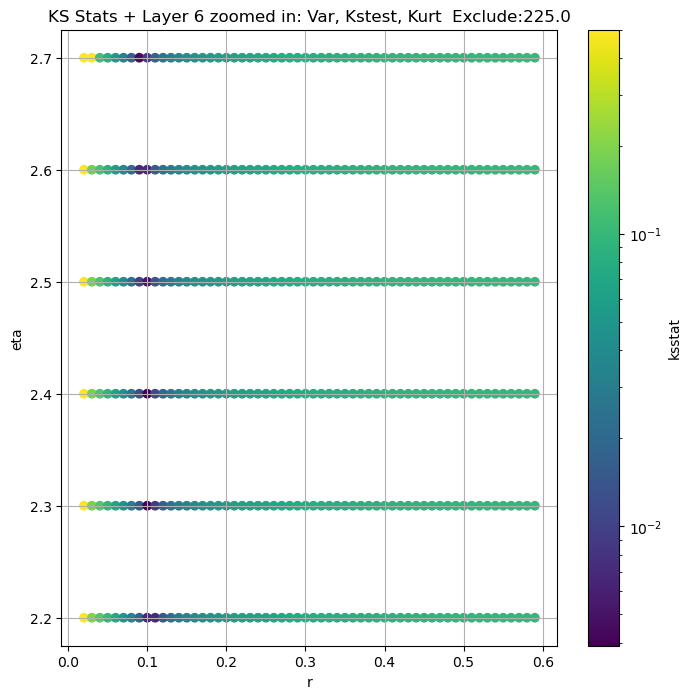

Layer 7


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 100 = 250, ksstat: 0.003654106520389888, var: 38.34227752685547


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 75 = 225, ksstat: 0.0032993222642976328, var: 39.33523941040039


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 50 = 200, ksstat: 0.002936490481219689, var: 40.45402526855469


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 25 = 175, ksstat: 0.0029707571644677078, var: 41.73316955566406


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 0 = 150, ksstat: 0.0028344454169968447, var: 43.218170166015625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -25 = 125, ksstat: 0.0036468253297223807, var: 44.98777389526367


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -50 = 100, ksstat: 0.004451479344344311, var: 47.162109375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -75 = 75, ksstat: 0.0061545086566222595, var: 49.99418258666992


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -100 = 50, ksstat: 0.00739345417914361, var: 54.04283905029297
Number of samples: 100000, Without approximation : 9216000


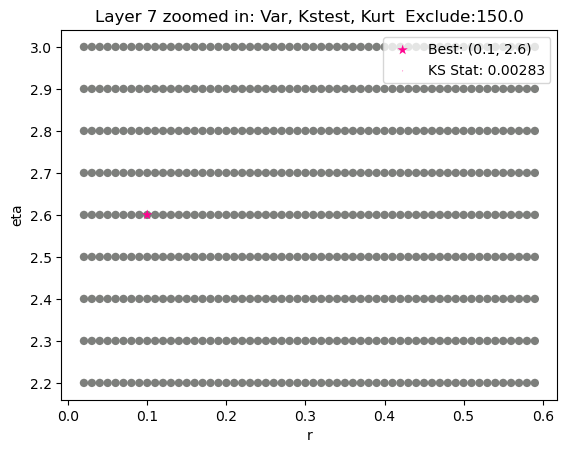

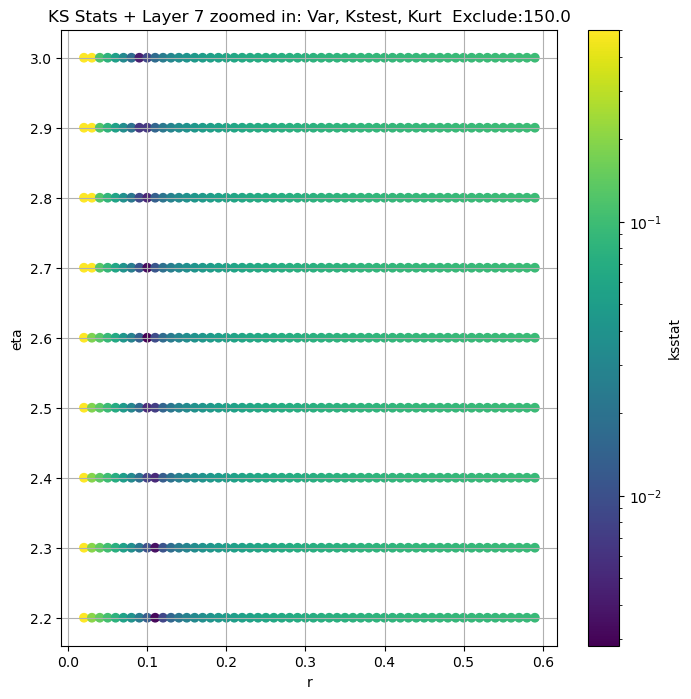

Layer 8


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 8, 150.0 + 100 = 250, ksstat: 0.003634163607572516, var: 14.259912490844727


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 8, 150.0 + 75 = 225, ksstat: 0.0032141429978631564, var: 14.590461730957031


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 8, 150.0 + 50 = 200, ksstat: 0.0027781970015061663, var: 14.96527099609375


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 8, 150.0 + 25 = 175, ksstat: 0.0023823822710875575, var: 15.398585319519043


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 8, 150.0 + 0 = 150, ksstat: 0.0020965447576800633, var: 15.912365913391113


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 8, 150.0 + -25 = 125, ksstat: 0.0021313766114685606, var: 16.542491912841797


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 8, 150.0 + -50 = 100, ksstat: 0.002967568122926978, var: 17.35056495666504


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 8, 150.0 + -75 = 75, ksstat: 0.004466436743286395, var: 18.46615982055664


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
layer 8, 150.0 + -100 = 50, ksstat: 0.006483378792780714, var: 20.164926528930664
Number of samples: 100000, Without approximation : 36864000


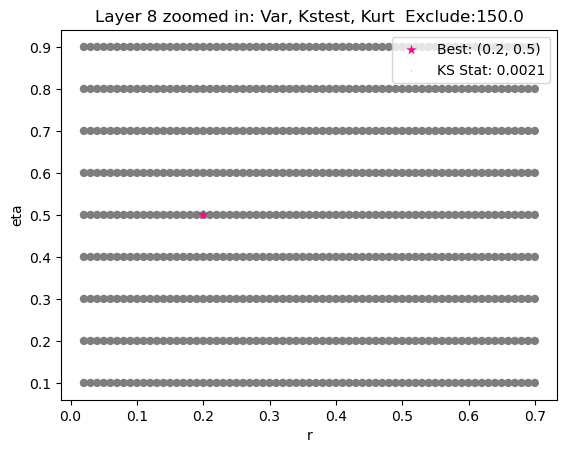

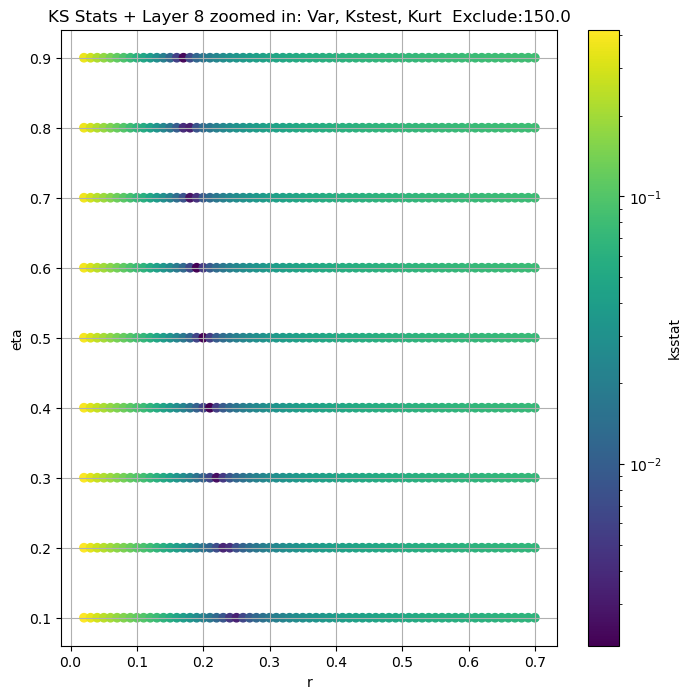

Layer 9


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 150.0 + 100 = 250, ksstat: 0.004112693519460545, var: 3.5662505626678467


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 150.0 + 75 = 225, ksstat: 0.0035878405598392567, var: 3.657470226287842


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 150.0 + 50 = 200, ksstat: 0.0030999559954032023, var: 3.7611093521118164


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 150.0 + 25 = 175, ksstat: 0.0026735428682280234, var: 3.880939483642578


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 150.0 + 0 = 150, ksstat: 0.0029921100258080147, var: 4.022894859313965


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 150.0 + -25 = 125, ksstat: 0.0031385293953570814, var: 4.197269916534424


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 150.0 + -50 = 100, ksstat: 0.004433013150381138, var: 4.422392845153809


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 150.0 + -75 = 75, ksstat: 0.0059874931028218725, var: 4.736510753631592


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 150.0 + -100 = 50, ksstat: 0.007586290170178311, var: 5.232006549835205
Number of samples: 100000, Without approximation : 147456000


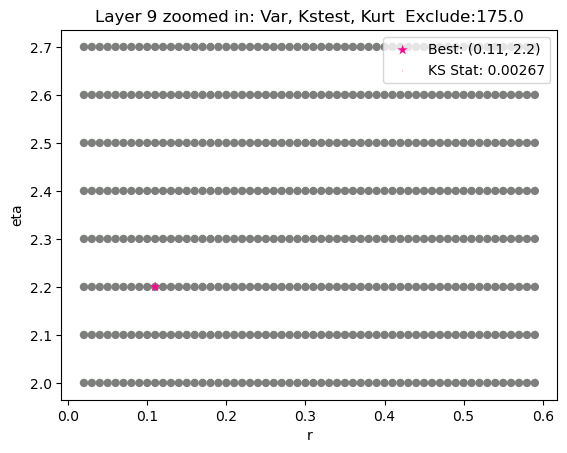

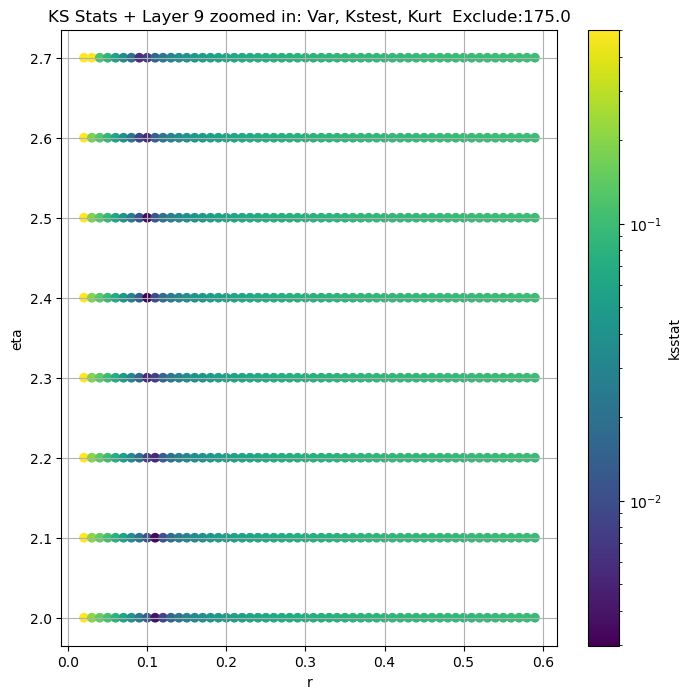

Layer 10


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 300.0 + 100 = 400, ksstat: 0.006763527555429971, var: 0.4221474528312683


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 300.0 + 75 = 375, ksstat: 0.006377143208774361, var: 0.4300272464752197


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 300.0 + 50 = 350, ksstat: 0.005962725654772072, var: 0.4385029971599579


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 300.0 + 25 = 325, ksstat: 0.005712258498339895, var: 0.44767218828201294


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 300.0 + 0 = 300, ksstat: 0.005498040509127999, var: 0.4576572775840759


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 300.0 + -25 = 275, ksstat: 0.005471081072166206, var: 0.46861395239830017


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 300.0 + -50 = 250, ksstat: 0.005641782640040893, var: 0.4807453751564026


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 300.0 + -75 = 225, ksstat: 0.005536449862060228, var: 0.49432501196861267


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 300.0 + -100 = 200, ksstat: 0.006089129279045036, var: 0.5097341537475586
Number of samples: 100000, Without approximation : 589824000


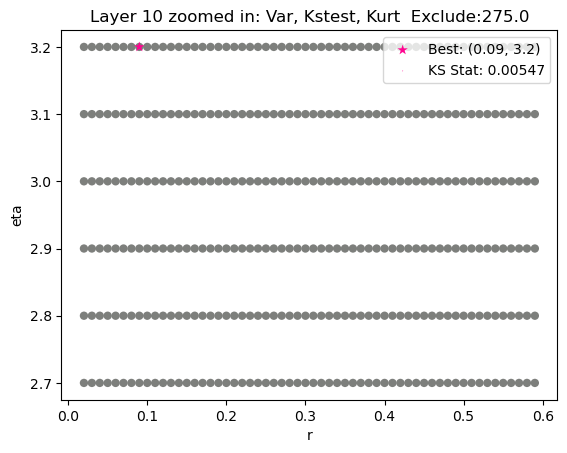

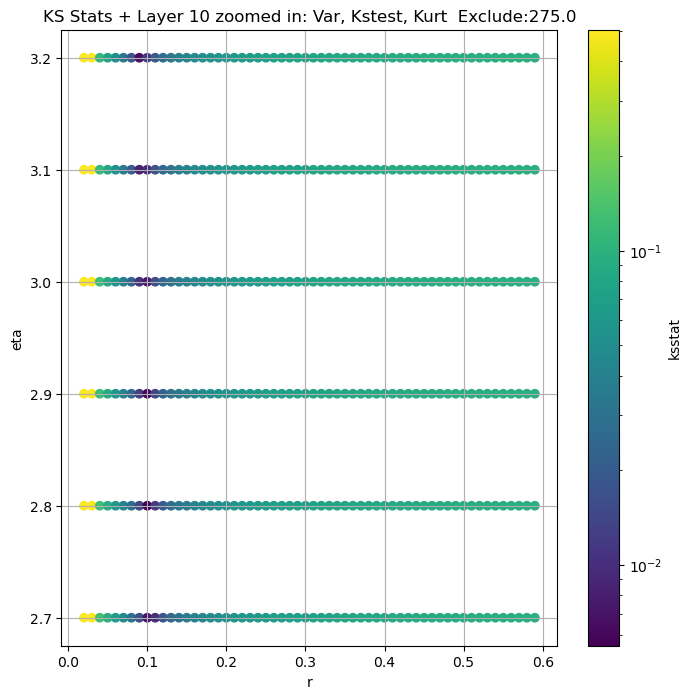

obs_var      var_lower      var_upper     obs_kurt  kurt_lower  \
layer                                                                         
2      179849.670000  104861.120000  313799.060000    501.36950   36.679760   
3       48276.574000   29688.229000   75748.940000    352.49057   90.250230   
4       13505.842000    6427.289000   29258.977000   1066.33460  112.394750   
5        3324.662400    1098.296600   15507.862000   6605.85100   86.610340   
6         902.707800     217.919700    6910.355000  18930.71300   76.715860   
7         249.830380      58.962917    1794.096000  19065.92400   51.230747   
8          57.422370      22.250046     277.044700   8522.20500   61.003616   
9          14.426312       5.903421      62.549038   6464.18550   77.169460   
10          2.155396       0.812531       9.592564   6981.02830   80.402470   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       756.93090           9000             0.011223        0.2          0.2   
3       561.88666          36000             0.010554        0.1          1.6   
4      2700.87100         144000             0.006805        0.1          1.2   
5      7123.14500         576000             0.006046        0.1          1.7   
6      8727.08600        2304000             0.003903        0.1          2.3   
7      8605.30900        9216000             0.002834        0.1          2.6   
8      6912.42770       36864000             0.002097        0.2          0.5   
9      6431.98000      147456000             0.002992        0.1          2.4   
10     6665.14160      589824000             0.005529        0.1          2.8   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       6.077028e-01                    25.0        74068.046875   
3       4.795898e-12                   150.0        16572.769531   
4       3.266162e-12                   350.0         3012.686300   
5       1.261962e-13                   350.0          545.068848   
6       6.679075e-15                   250.0          129.642426   
7       1.159409e-15                   150.0           43.218170   
8       6.623529e-05                   150.0           15.912366   
9       1.694925e-16                   150.0            3.880939   
10      7.972053e-18                   300.0            0.468614   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.014297          0.010457    0.23       0.0   
3                     0.007153          0.009386    0.09       1.7   
4                     0.003578          0.006805    0.10       1.2   
5                     0.001789          0.005407    0.09       1.9   
6                     0.000895          0.003637    0.09       2.7   
7                     0.000447          0.002834    0.10       2.6   
8                     0.000224          0.002097    0.20       0.5   
9                     0.000112          0.002674    0.11       2.2   
10                    0.000056          0.005471    0.09       3.2   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      8.296568e+00                 25.0        17085  
3      2.293902e-14                100.0        20250  
4      3.266162e-12                350.0        40500  
5      4.159379e-16                300.0        60750  
6      1.205382e-17                225.0       144000  
7      1.159409e-15                150.0       243000  
8      6.623529e-05                150.0       432000  
9      1.861937e-14                175.0       273375  
10     1.396887e-20                275.0        60750

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

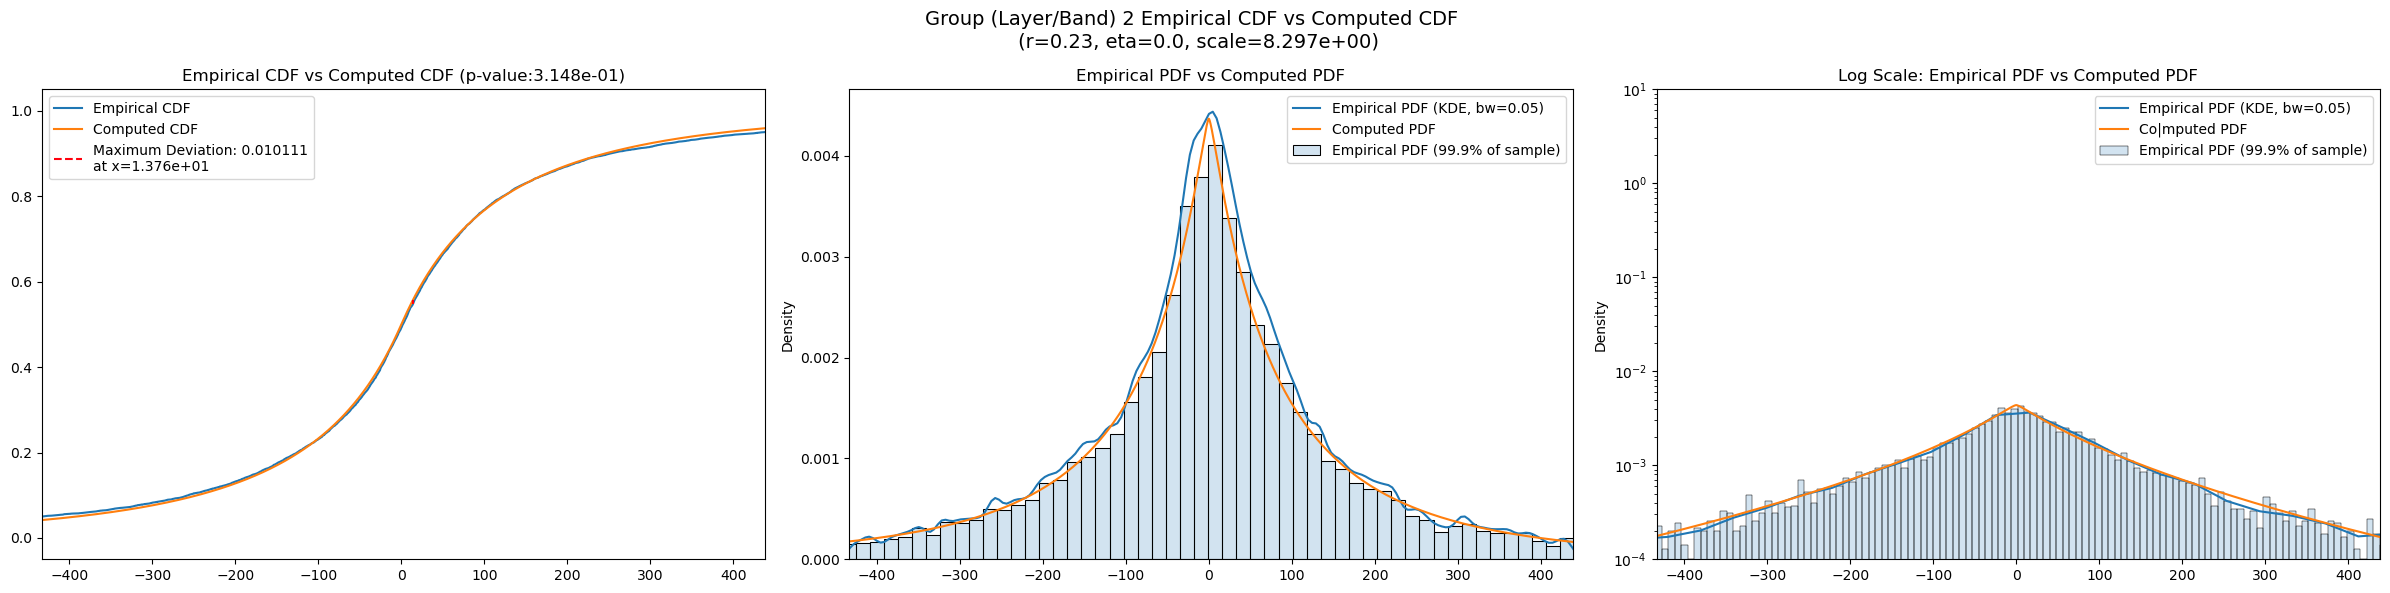

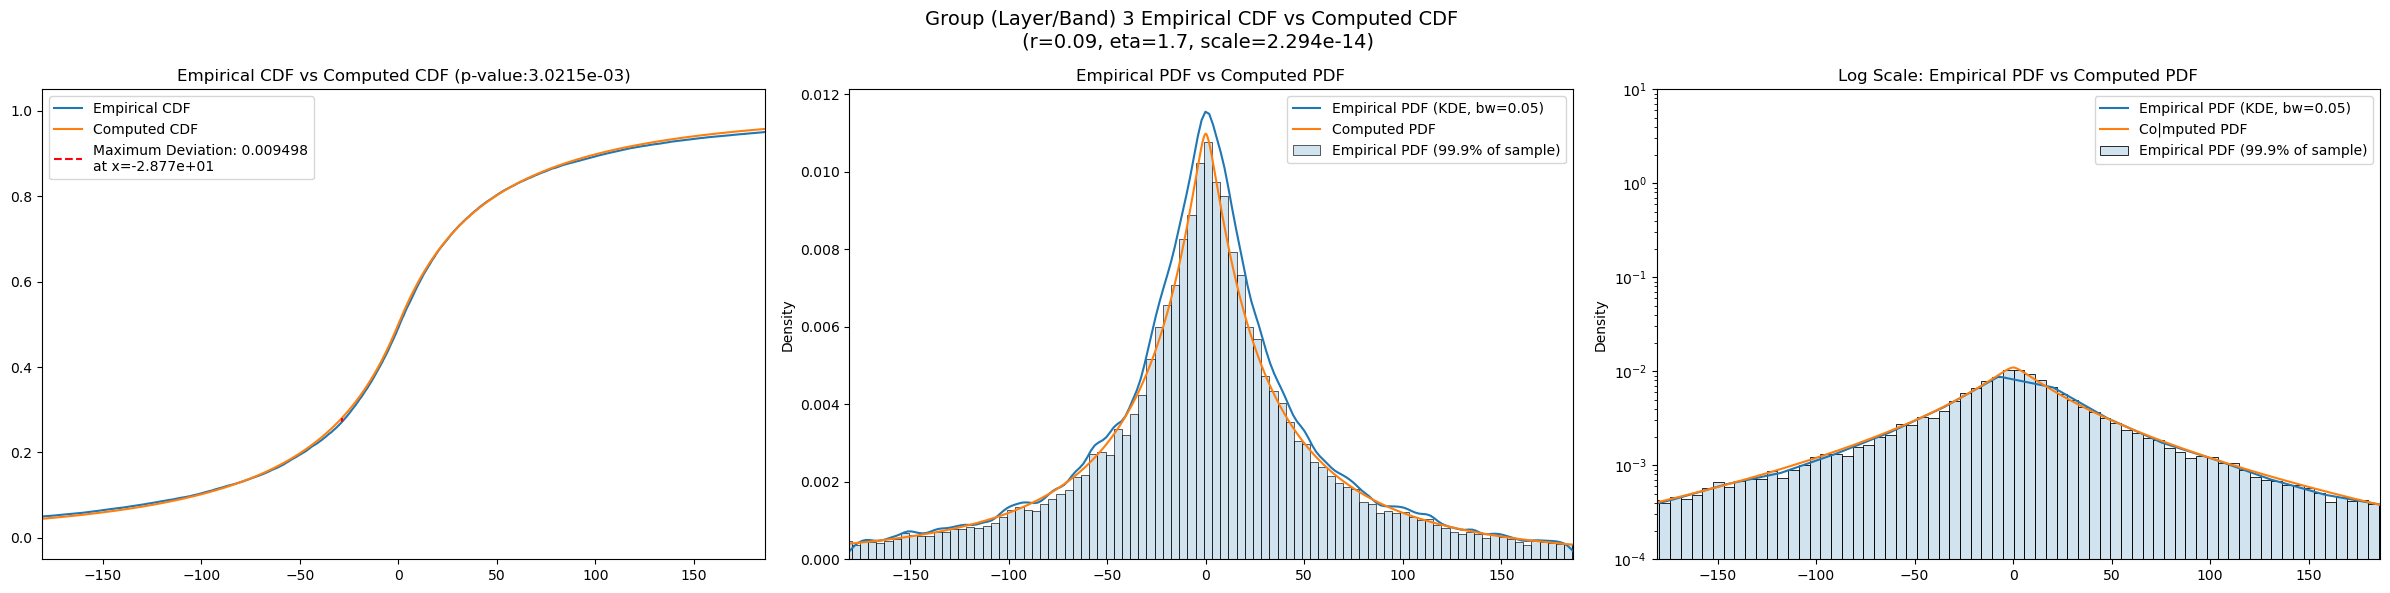

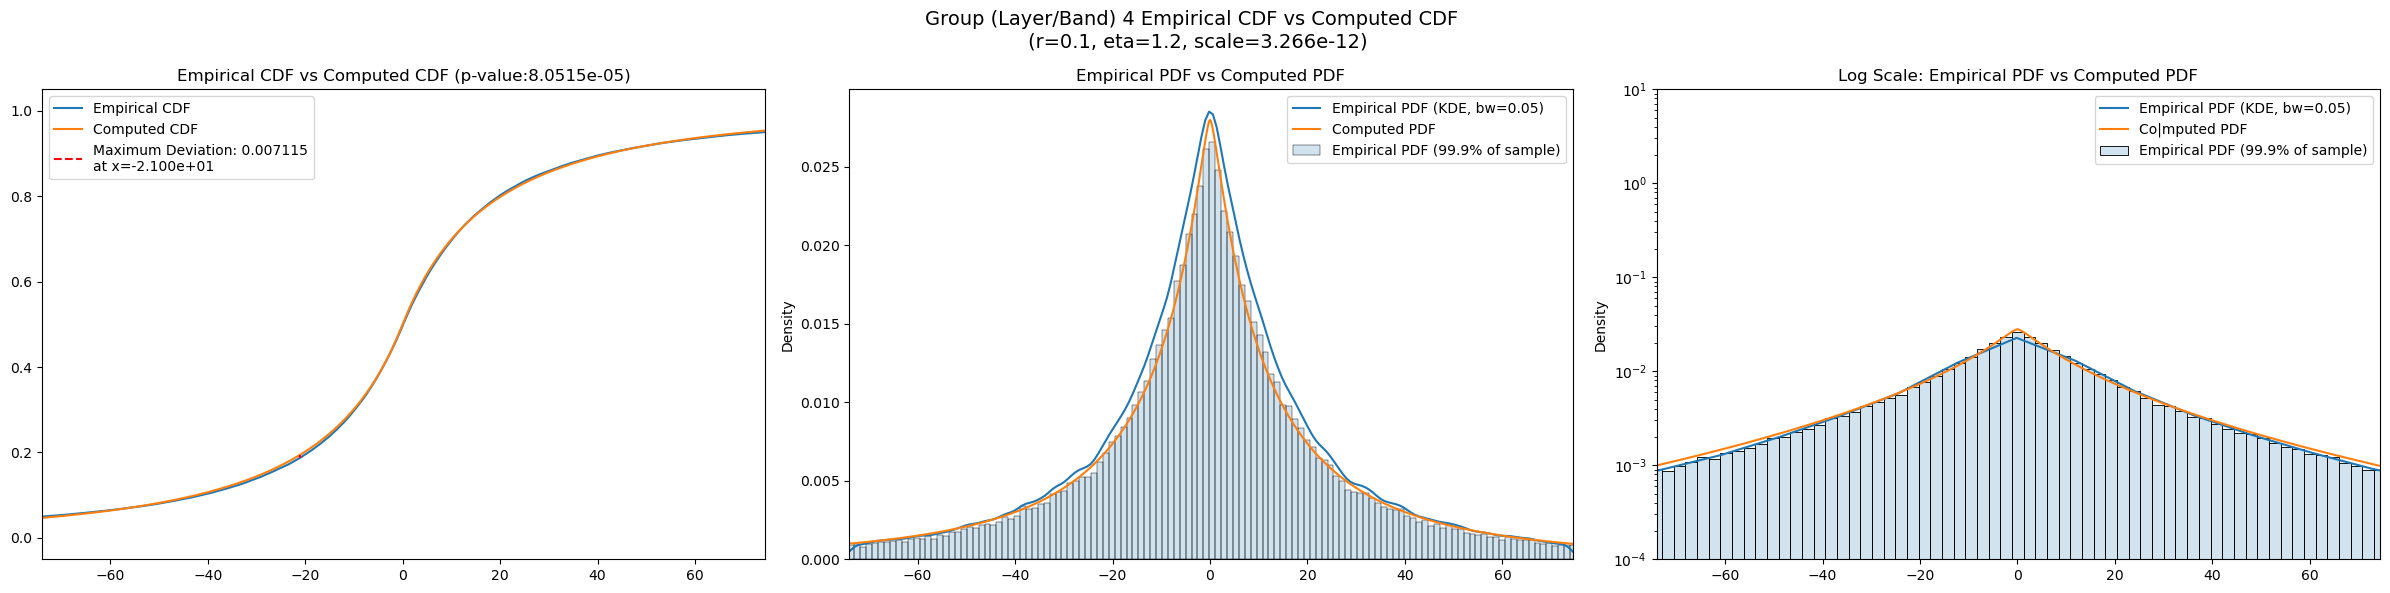

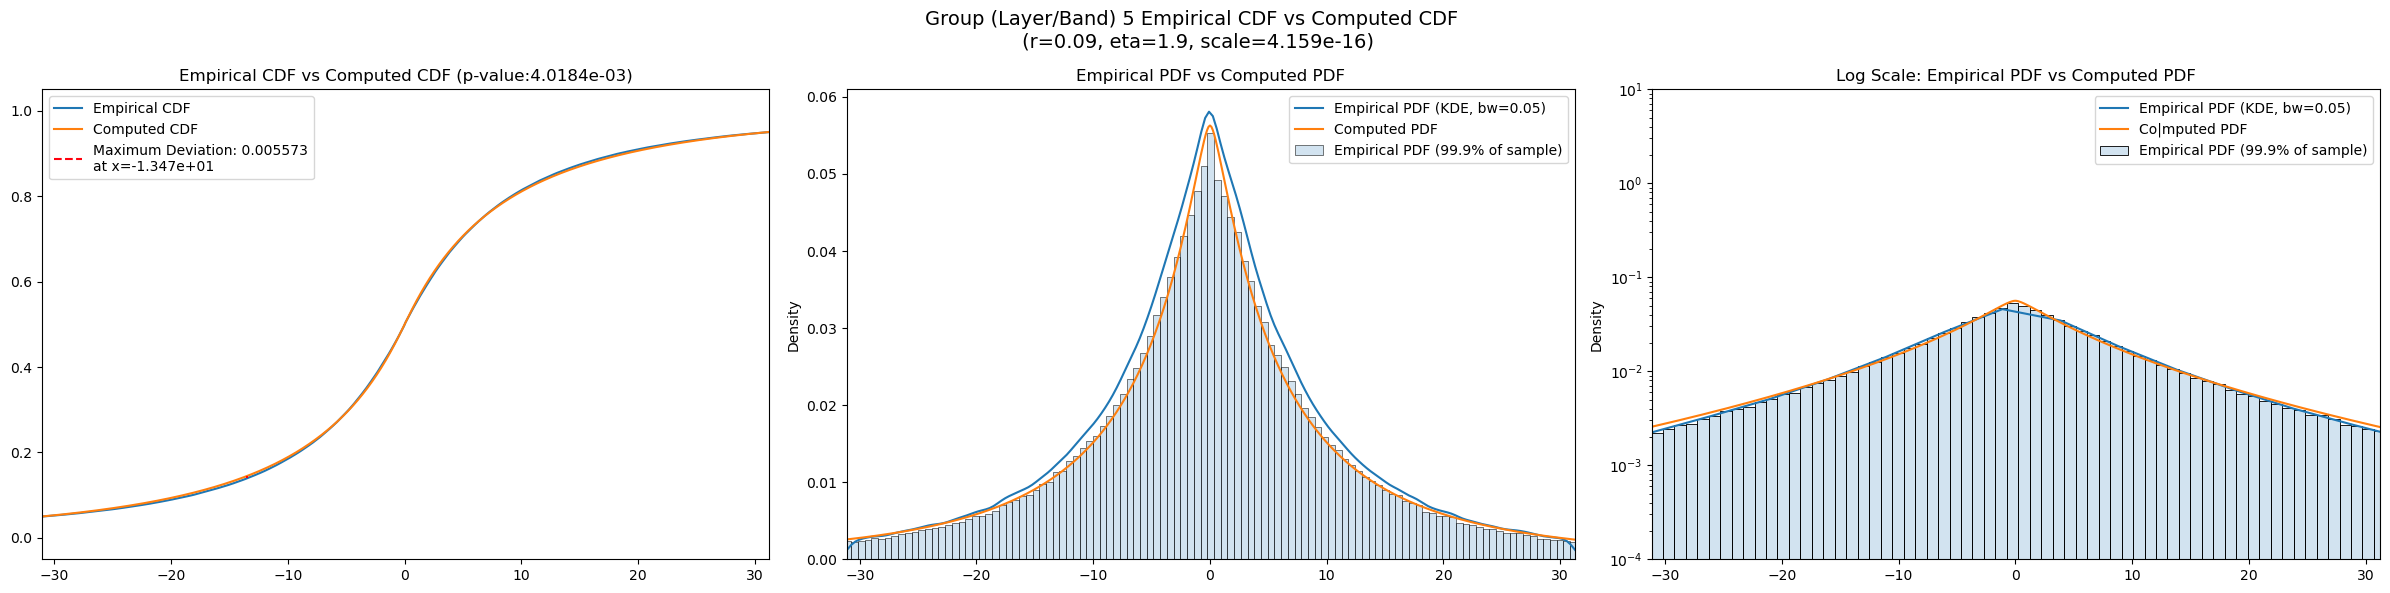

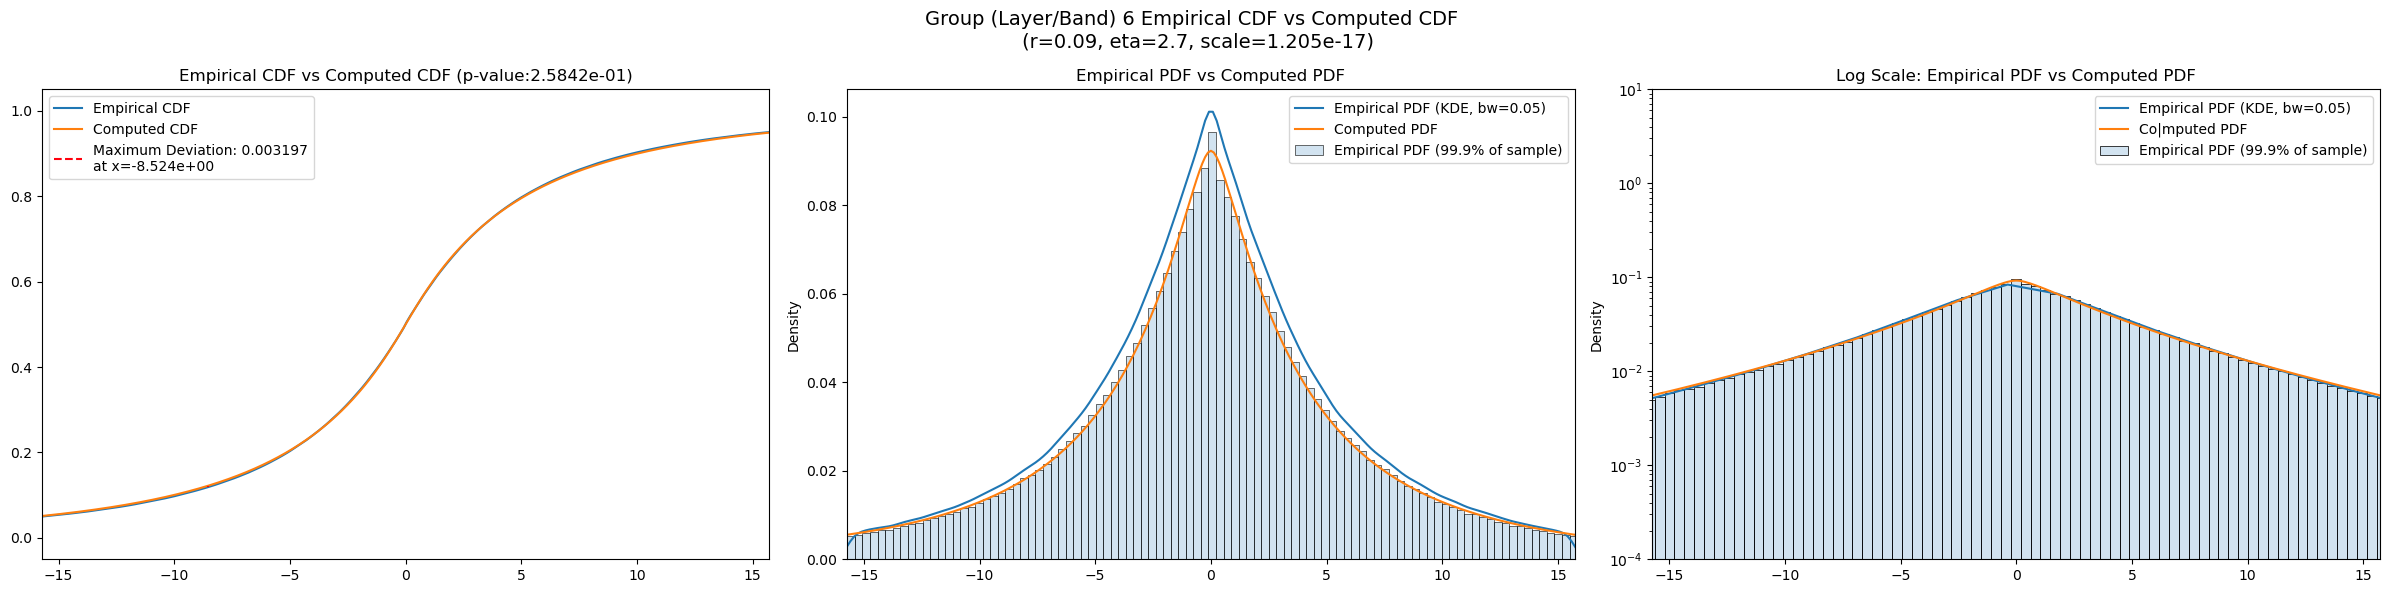

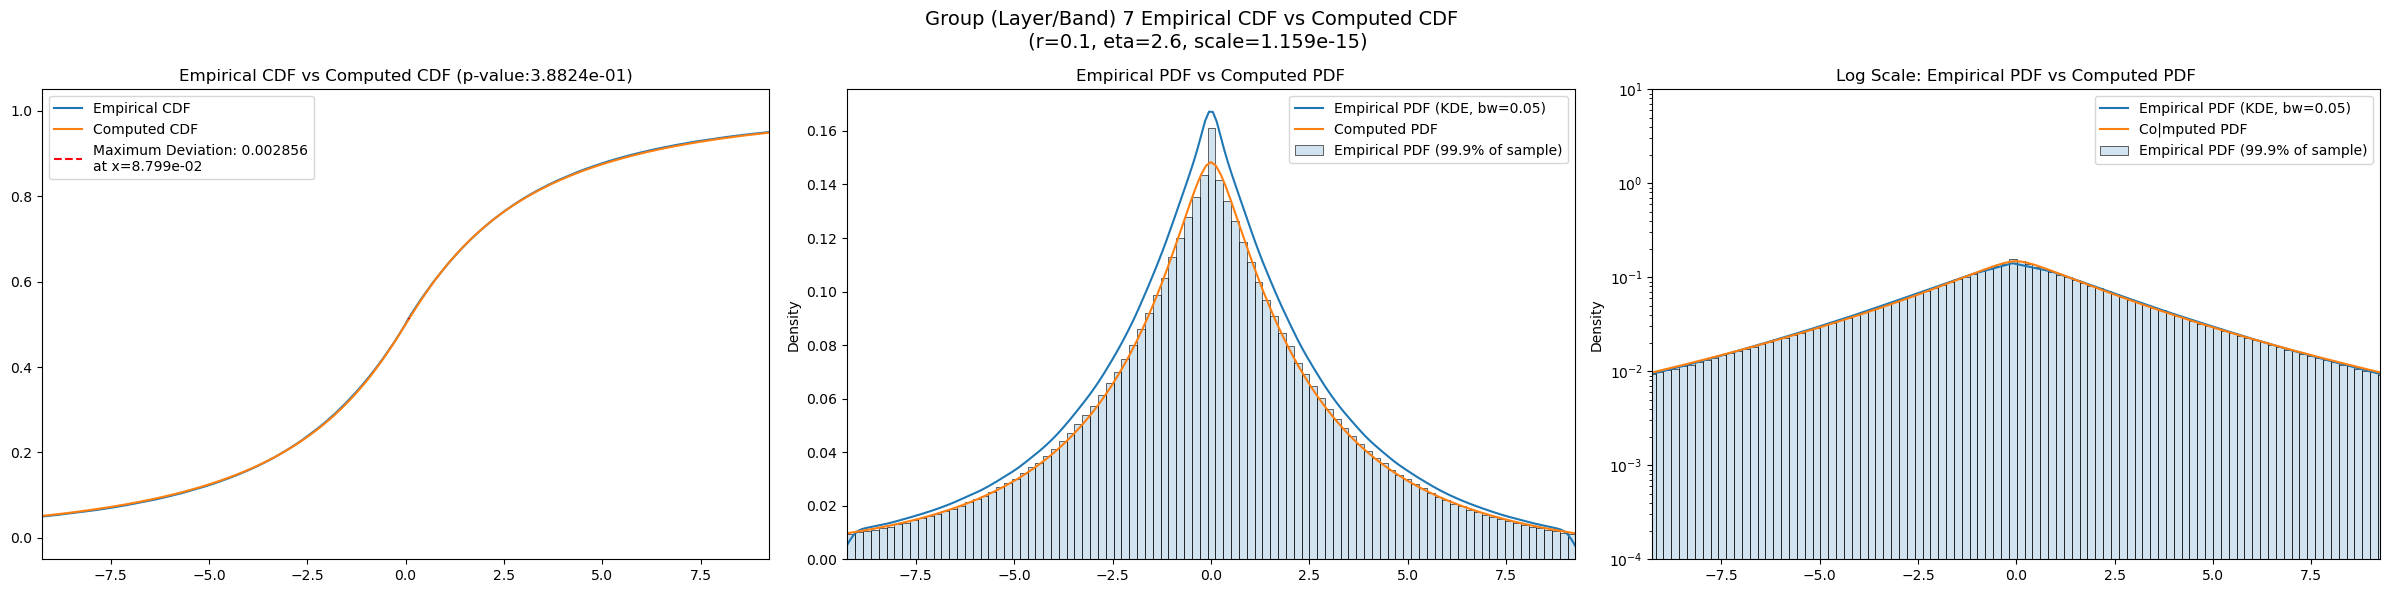

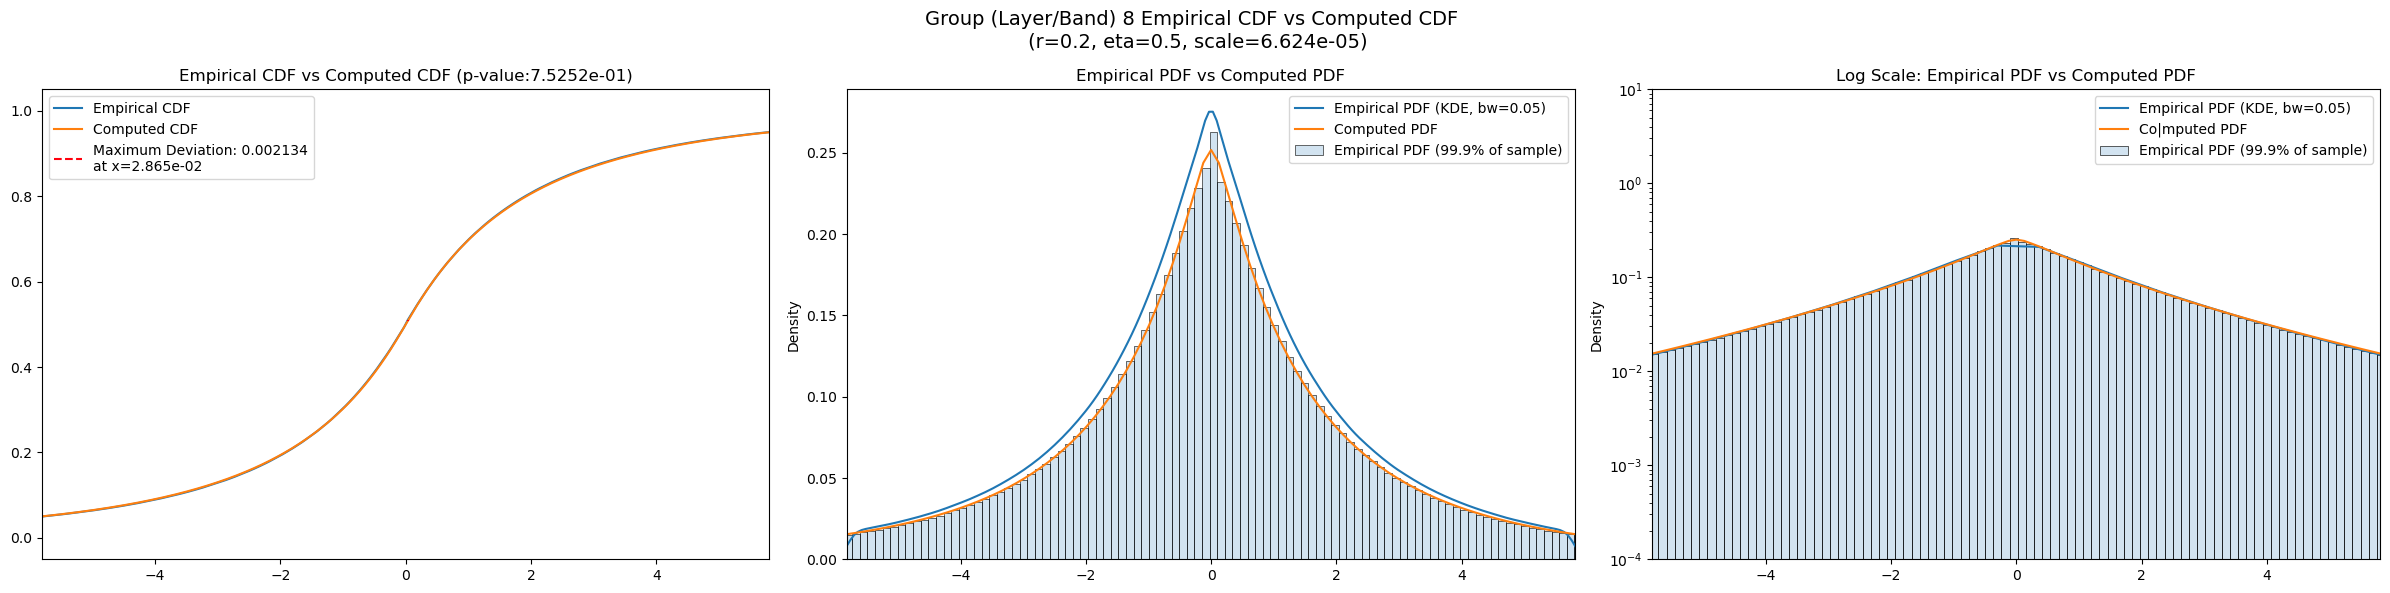

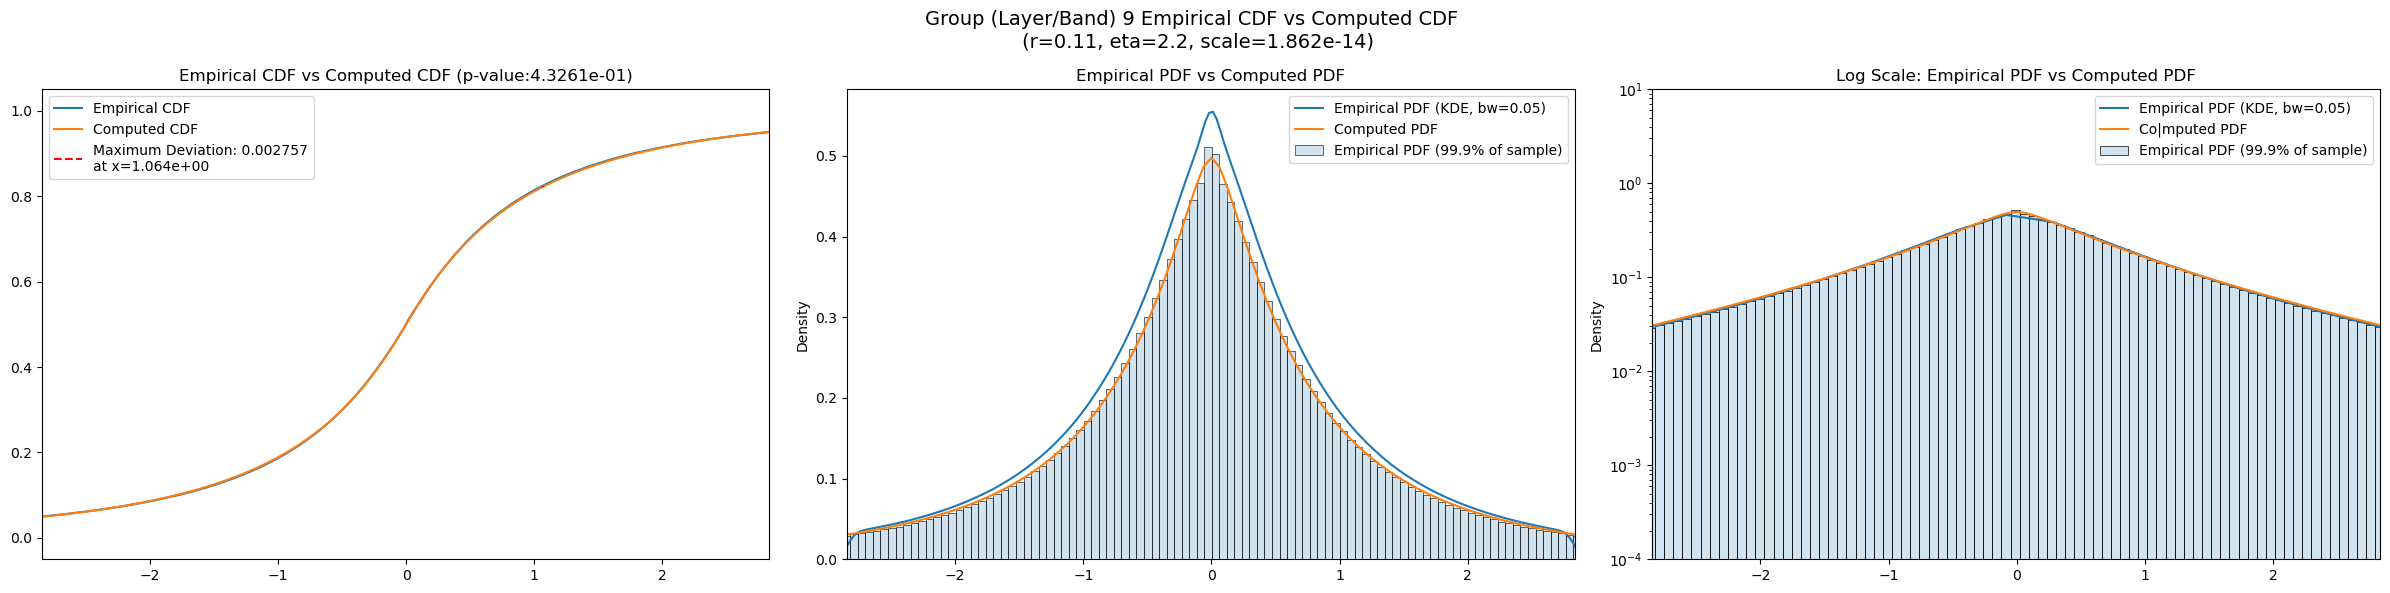

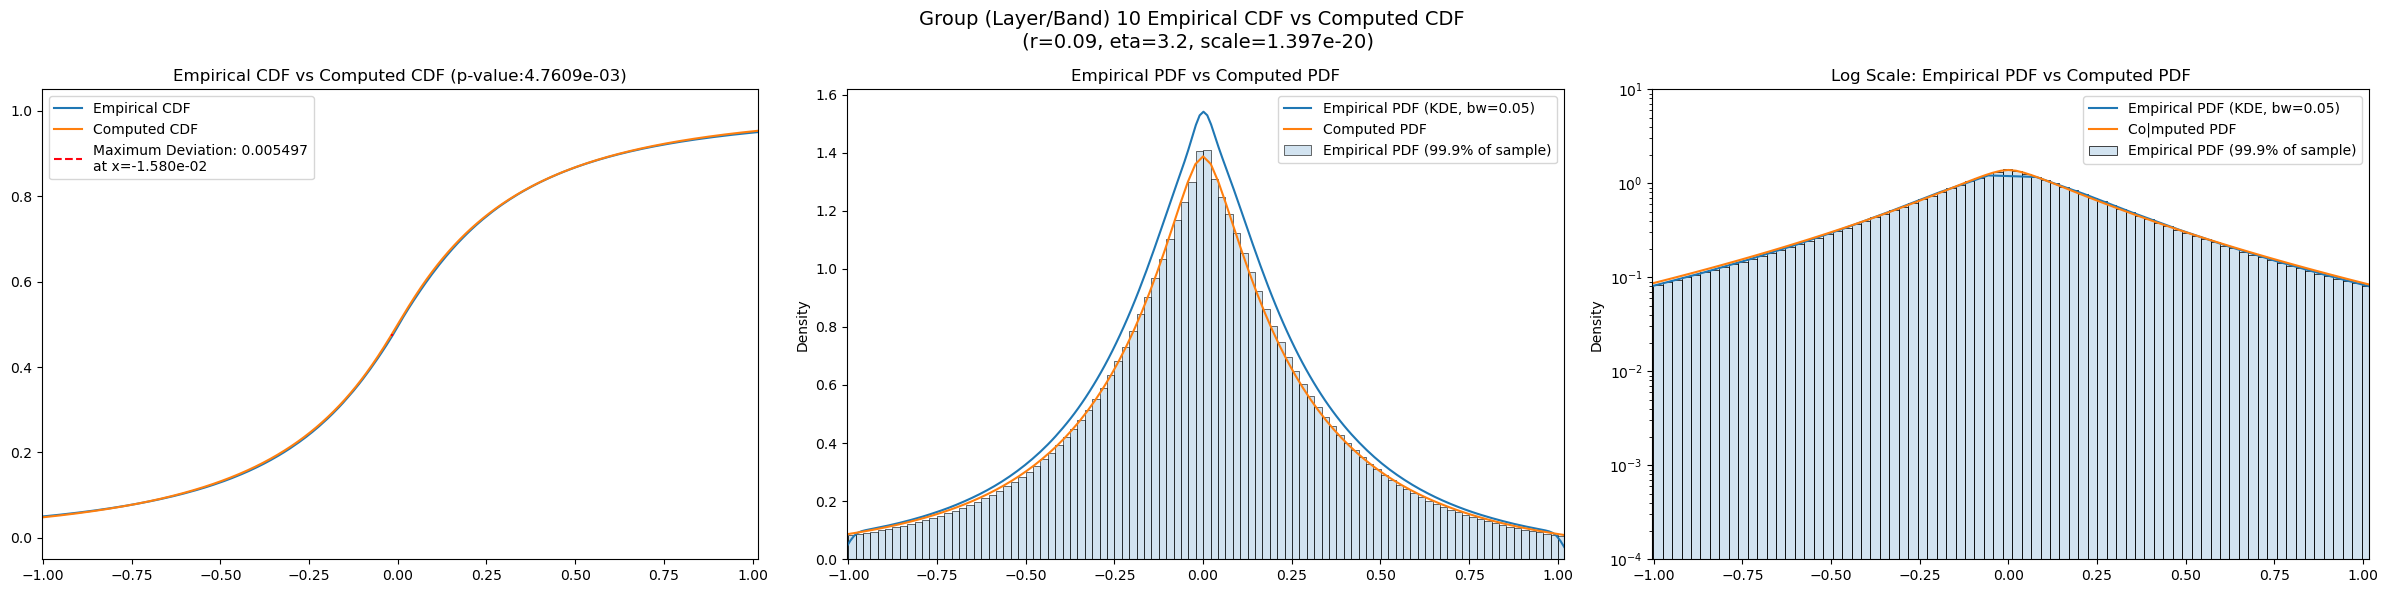

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var      var_lower      var_upper     obs_kurt  kurt_lower  \
layer                                                                         
2      179849.670000  104861.120000  313799.060000    501.36950   36.679760   
3       48276.574000   29688.229000   75748.940000    352.49057   90.250230   
4       13505.842000    6427.289000   29258.977000   1066.33460  112.394750   
5        3324.662400    1098.296600   15507.862000   6605.85100   86.610340   
6         902.707800     217.919700    6910.355000  18930.71300   76.715860   
7         249.830380      58.962917    1794.096000  19065.92400   51.230747   
8          57.422370      22.250046     277.044700   8522.20500   61.003616   
9          14.426312       5.903421      62.549038   6464.18550   77.169460   
10          2.155396       0.812531       9.592564   6981.02830   80.402470   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       756.93090           9000             0.011223        0.2          0.2   
3       561.88666          36000             0.010554        0.1          1.6   
4      2700.87100         144000             0.006805        0.1          1.2   
5      7123.14500         576000             0.006046        0.1          1.7   
6      8727.08600        2304000             0.003903        0.1          2.3   
7      8605.30900        9216000             0.002834        0.1          2.6   
8      6912.42770       36864000             0.002097        0.2          0.5   
9      6431.98000      147456000             0.002992        0.1          2.4   
10     6665.14160      589824000             0.005529        0.1          2.8   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...      161.254000              0.054760          6.733760e-24   
3      ...       64.405300              0.057941         1.702520e-105   
4      ...       26.438000              0.054954          0.000000e+00   
5      ...       12.265500              0.048011          0.000000e+00   
6      ...        6.732260              0.041887          0.000000e+00   
7      ...        4.053610              0.040119          0.000000e+00   
8      ...        2.495720              0.042207          0.000000e+00   
9      ...        1.215720              0.042166          0.000000e+00   
10     ...        0.428473              0.043212          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace     param_t  \
layer                                                                        
2         142.138000             0.028675         7.309540e-07  111.140000   
3          57.131200             0.031859         3.515010e-32   45.016300   
4          23.537900             0.029322        5.443130e-108   18.354100   
5          10.940300             0.022886        1.619610e-262    8.580610   
6           5.972650             0.016287         0.000000e+00    4.733790   
7           3.588670             0.013907         0.000000e+00    2.852920   
8           2.201350             0.015275         0.000000e+00    1.757830   
9           1.074530             0.015888         0.000000e+00    0.855868   
10          0.379368             0.017165         0.000000e+00    0.300864   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.028434   9.365760e-07          2.767070e-01  
3           0.029360   2.152740e-27          3.494208e-03  
4           0.026348   2.803460e-87          3.215494e-06  
5           0.018525  3.918260e-172          4.716082e-15  
6           0.013582   0.000000e+00          6.787905e-27  
7           0.013128   0.000000e+00          9.728998e-65  
8           0.015164   0.000000e+00         3.614051e-141  
9           0.013912   0.000000e+00  

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.011223                 0.014297          0.010457   
3                 0.010554                 0.007153          0.009386   
4                 0.006805                 0.003578          0.006805   
5                 0.006046                 0.001789          0.005407   
6                 0.003903                 0.000895          0.003637   
7                 0.002834                 0.000447          0.002834   
8                 0.002097                 0.000224          0.002097   
9                 0.002992                 0.000112          0.002674   
10                0.005529                 0.000056          0.005471   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.054760             0.028675       0.028434  
3                  0.057941             0.031859       0.029360  
4                  0.054954             0.029322       0.026348  
5                  0.048011             0.022886       0.018525  
6                  0.041887             0.016287       0.013582  
7                  0.040119             0.013907       0.013128  
8                  0.042207             0.015275       0.015164  
9                  0.042166             0.015888       0.013912  
10                 0.043212             0.017165       0.015182

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            74068.046875          0.010457    0.23       0.0  8.296568e+00   
3            16572.769531          0.009386    0.09       1.7  2.293902e-14   
4             3012.686300          0.006805    0.10       1.2  3.266162e-12   
5              545.068848          0.005407    0.09       1.9  4.159379e-16   
6              129.642426          0.003637    0.09       2.7  1.205382e-17   
7               43.218170          0.002834    0.10       2.6  1.159409e-15   
8               15.912366          0.002097    0.20       0.5  6.623529e-05   
9                3.880939          0.002674    0.11       2.2  1.861937e-14   
10               0.468614          0.005471    0.09       3.2  1.396887e-20   

       best_exclude_cutoff  
layer                       
2                     25.0  
3                    100.0  
4                    350.0  
5                    300.0  
6                    225.0  
7                    150.0  
8                    150.0  
9                    175.0  
10                   275.0

In [21]:
eng.quit()